In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

import xarray
from scipy.signal import sweep_poly

from hdpgpc.get_data import compute_estimators_LDS
import math
from scipy.fft import fft
import h5py
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import wavespectra as wv
import xarray as xr
import importlib
import pickle
import hdpgpc.GPI_HDP as hdpgp
import re
from datetime import datetime, timedelta
import time

/tmp/ipykernel_1946602/314496333.py:8: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.signal import sweep_poly
/home/adrian.perez/Documents/OceanWave/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)

<module 'hdpgpc.util_plots' from '/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/util_plots.py'>

---

### 1. Lectura de datos

In [3]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'ocean', 'wawaves')
f_hillary = h5py.File(os.path.join(data_path, 'Hillarys_202407.mat'),'r')
#f = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting03_202406.mat'),'r')
print(f_hillary.get('SpotData').keys())
direction = np.array(f_hillary.get('SpotData/direction'))
variance_density = np.array(f_hillary.get('SpotData/varianceDensity'))
spec_time_hillarys = np.array(f_hillary.get('SpotData/spec_time'))
time = np.array(f_hillary.get('SpotData/time'))
frequency_hillarys = np.array(f_hillary.get('SpotData/frequency'))
a1 = np.array(f_hillary.get('SpotData/a1'))
a2 = np.array(f_hillary.get('SpotData/a2'))
b1 = np.array(f_hillary.get('SpotData/b1'))
b2 = np.array(f_hillary.get('SpotData/b2'))

<KeysViewHDF5 ['a1', 'a2', 'b1', 'b2', 'bott_temp', 'df', 'direction', 'directionalSpread', 'dm', 'dm_sea', 'dm_swell', 'dmspr', 'dmspr_sea', 'dmspr_swell', 'dp', 'dpspr', 'endFreq_sea', 'endFreq_swell', 'frequency', 'hsig', 'hsig_sea', 'hsig_swell', 'lat', 'lon', 'name', 'part_time', 'press_std_time', 'press_time', 'pressure', 'pressure_std', 'qf_bott_temp', 'qf_sst', 'qf_waves', 'serialID', 'spec_time', 'startFreq_sea', 'startFreq_swell', 'surf_temp', 'temp_time', 'time', 'tm', 'tm_sea', 'tm_swell', 'tp', 'varianceDensity', 'wind_dir', 'wind_seasurfaceId', 'wind_speed', 'wind_time']>


In [4]:
print("Shape of the data: ")
print(variance_density.shape)
num_obs_per_sample, num_samples  = variance_density.shape

Shape of the data: 
(79, 1473)


In [5]:
S_theta =  np.zeros((variance_density.shape[1], variance_density.shape[0], 37))
directions = np.deg2rad(np.linspace(0, 360.0, 37))
delta_theta = np.deg2rad(10.0)
for t in range(S_theta.shape[0]):
    for f in range(S_theta.shape[1]):
        # Load S(f), a1, b1, a2, b2 for this time and frequency
        S = variance_density[f, t]# Omnidirectional spectrum
        a1_, b1_, a2_, b2_ = a1[f,t], b1[f,t], a2[f,t], b2[f,t]  # Directional moments

        for i, theta in enumerate(directions):
            # Compute D(f, theta)
            D = (1 /  np.pi) * (
                1/2 + (a1_ * np.cos(theta) + b1_ * np.sin(theta))
                  + (a2_ * np.cos(2 * theta) + b2_ * np.sin(2 * theta))
            )

            # Ensure non-negativity
            D = max(D, 0)

            # Compute S(f, theta)
            S_theta[t, f, i] = S * D

        # Optional: Renormalize to ensure sum(S_theta * delta_theta) ≈ S
        integral = np.sum(S_theta[t, f, :]) * delta_theta
        integral = integral if integral > 0 else 1.0
        S_theta[t, f, :] *= S / integral  # Adjust if integral != S

In [6]:
#Trying to transform data and direction to 3 dim data.
# direction_segments = np.floor(direction / 5.0).astype(np.int32)
# data_np = np.zeros((variance_density.shape[1], variance_density.shape[0], 73))
# for i, d in enumerate(data_np):
#     for t, dir in enumerate(direction_segments[:, i]):
#         d[t,dir] = d[t,dir] + variance_density[t, i]
dirs = np.linspace(0, 360.0, 37)
dirs = (dirs + 225.0) % 360.0
dataset = xr.Dataset(
    data_vars=dict(
        efth=(["time", "freq", "dir"], S_theta)
    ),
    coords=dict(
        time=(["time"], spec_time_hillarys[0]),
        freq=(["freq"], frequency_hillarys[:,0]),
        dir=(["dir"], dirs)
    )
)
dts_hillarys = wv.SpecDataset(dataset)
new_dirs = np.linspace(0, 360, 37)  # Cada 10° incluyendo 360°
data_ = dts_hillarys.interp(dir=new_dirs)
freq = data_.freq
freq_hillarys = data_.freq


In [7]:
# times = np.arange(0,3) + 400
#
# fig, axs = plt.subplots(3, figsize=(9, 7))
# for i, ax in enumerate(axs.flat):
#     ds2 = data_.isel(time=[times[i]])
#     ds2.spec.plot(
#         normalised=False,
#         col="time",
#         figsize=(15, 8),
#         cmap="Spectral_r",
#     )

In [8]:
data = data_.to_numpy()
freq_ = np.array(freq)

Shape of hs: (1473, 1)
How much spectra falls in the range 0.5-1.5 Hs: 1473


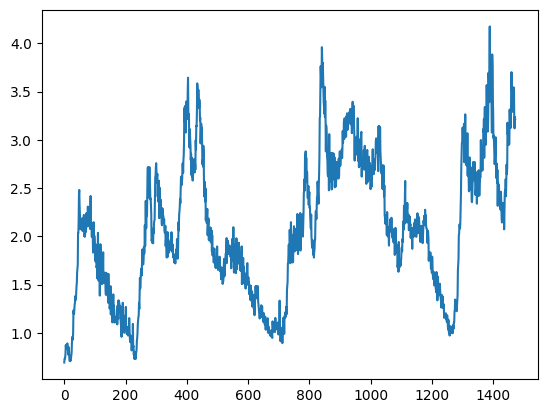

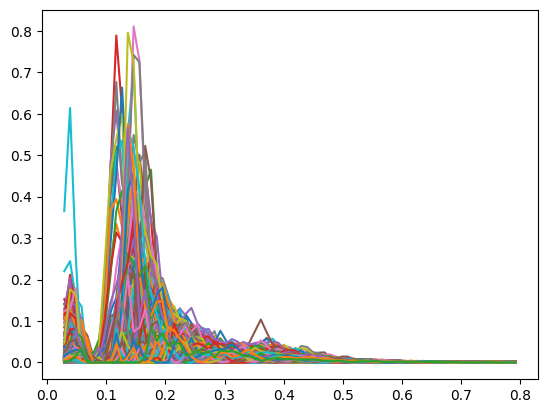

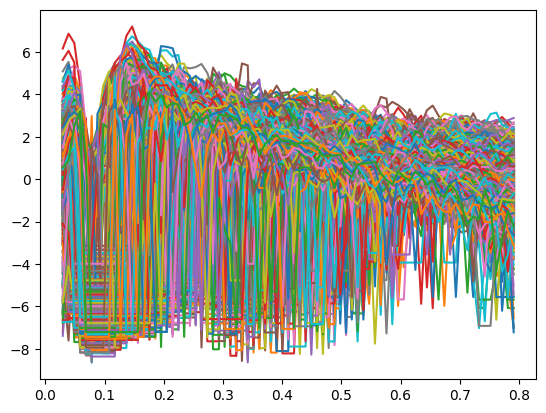

In [9]:
 #Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq_[1]-freq_[0], num_obs_per_sample)[:, np.newaxis]
hs_h = 4 * np.sqrt(np.sum(data, axis=2) * delta_theta @ interv)
print("Shape of hs: "+str(hs_h.shape))
plt.plot(hs_h)
chosen_indexes = np.where((hs_h > 0.5) & (hs_h < 1.5))[0]
chosen_indexes = np.arange(num_samples)
print("How much spectra falls in the range 0.5-1.5 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data[:,:,0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data + 1e-6) - np.mean(np.log(data+ 1e-6), axis=1)[:,np.newaxis,:]
plt.plot(freq, lognorm_data[:,:,0][chosen_indexes].T)
plt.show()


### Se cogen solo los datos de un año natural

In [10]:
#Select indexes
data = data[chosen_indexes]
print("Shape of the data: ")
print(data.shape)

num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(1473, 79, 37)


In [11]:
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=50, dim=25)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.5
std_dif = std_dif * 0.45
bound_sigma = (std * 1e-7, std * 1e-6)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-8)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 0.1
ini_lengthscale = 1e-3
bound_lengthscale = (1e-7, 5e-3)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
x_basis = np.atleast_2d(freq[0:40]).T
x_train = np.atleast_2d(freq[0:40]).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0] / 2.0, dtype=np.float64)).T

Sigma estimated: 0.022459413670951143
Gamma estimated: 0.022459413670951143
Final sigma: 0.011229706835475571
Final gamma: 0.010106736151928015
Final sigma bound: (1.122970683547557e-09, 1.122970683547557e-08)
Final gamma bound: (np.float64(1.0106736151928015e-11), np.float64(1.0106736151928016e-10))
(40, 1)


In [12]:
sw_gp_hillary = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=36,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=15, free_deg_MNIV=8, share_gp=True, use_snr=False, reduce_outputs=True, reduce_outputs_ratio=0.1)

num_samples = data.shape[0]
#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp_hillary.include_batch(x_trains, data[:,0:40,:])

------ HDP Hyperparameters ------
gamma: 0.8
transAlpha: 0.8
startAlpha: 0.8
kappa: 0.0
---------------------------------
Performed reduction of outputs based on variance.
Ratio of reduction: 0.1 Final outputs: [22 23 24 25]
Group responsability estimated: [1473]
---Kernel estimated---
1.56**2 * RBF(length_scale=0.0178) + WhiteKernel(noise_level=1.06e-08)
Step 1/15- Trying to divide: 0 with beat 1389
Sum resp_temp: [1451   22]
Q_em: -87788.82, Q_lat: -97008.93, Elbo_linear: -50.05, Elbo_LDS: -3979.74
>>> Q_all_loop -------
Sum resp_temp: [1451   22]
Q_em: -87788.82, Q_lat: -97008.93, Elbo_linear: -50.05, Elbo_LDS: -3979.74
Sum resp_temp: [1447   26]
Q_em: -87318.57, Q_lat: -96390.10, Elbo_linear: -49.30, Elbo_LDS: -3998.71
Sum resp_temp: [1447   26]
Q_em: -87318.57, Q_lat: -96390.10, Elbo_linear: -49.30, Elbo_LDS: -3998.71
ELBO_reduction: 1070.8475870451948
>>> Q_all_loop -------
Sum resp_temp: [1447   26]
Q_em: -87318.57, Q_lat: -96390.10, Elbo_linear: -49.30, Elbo_LDS: -3998.71
Sum r

Model 1 : MainModel: N : [N-520]
Model 2 : MainModel: N : [N-415]
Model 3 : MainModel: N : [N-289]
Model 4 : MainModel: N : [N-151]
Model 5 : MainModel: N : [N-40]
Model 6 : MainModel: N : [N-30]
Model 7 : MainModel: N : [N-24]
Model 8 : MainModel: N : [N-3]
Model 9 : MainModel: N : [N-1]
Classification error: 0 / 1473 -- 0.00000


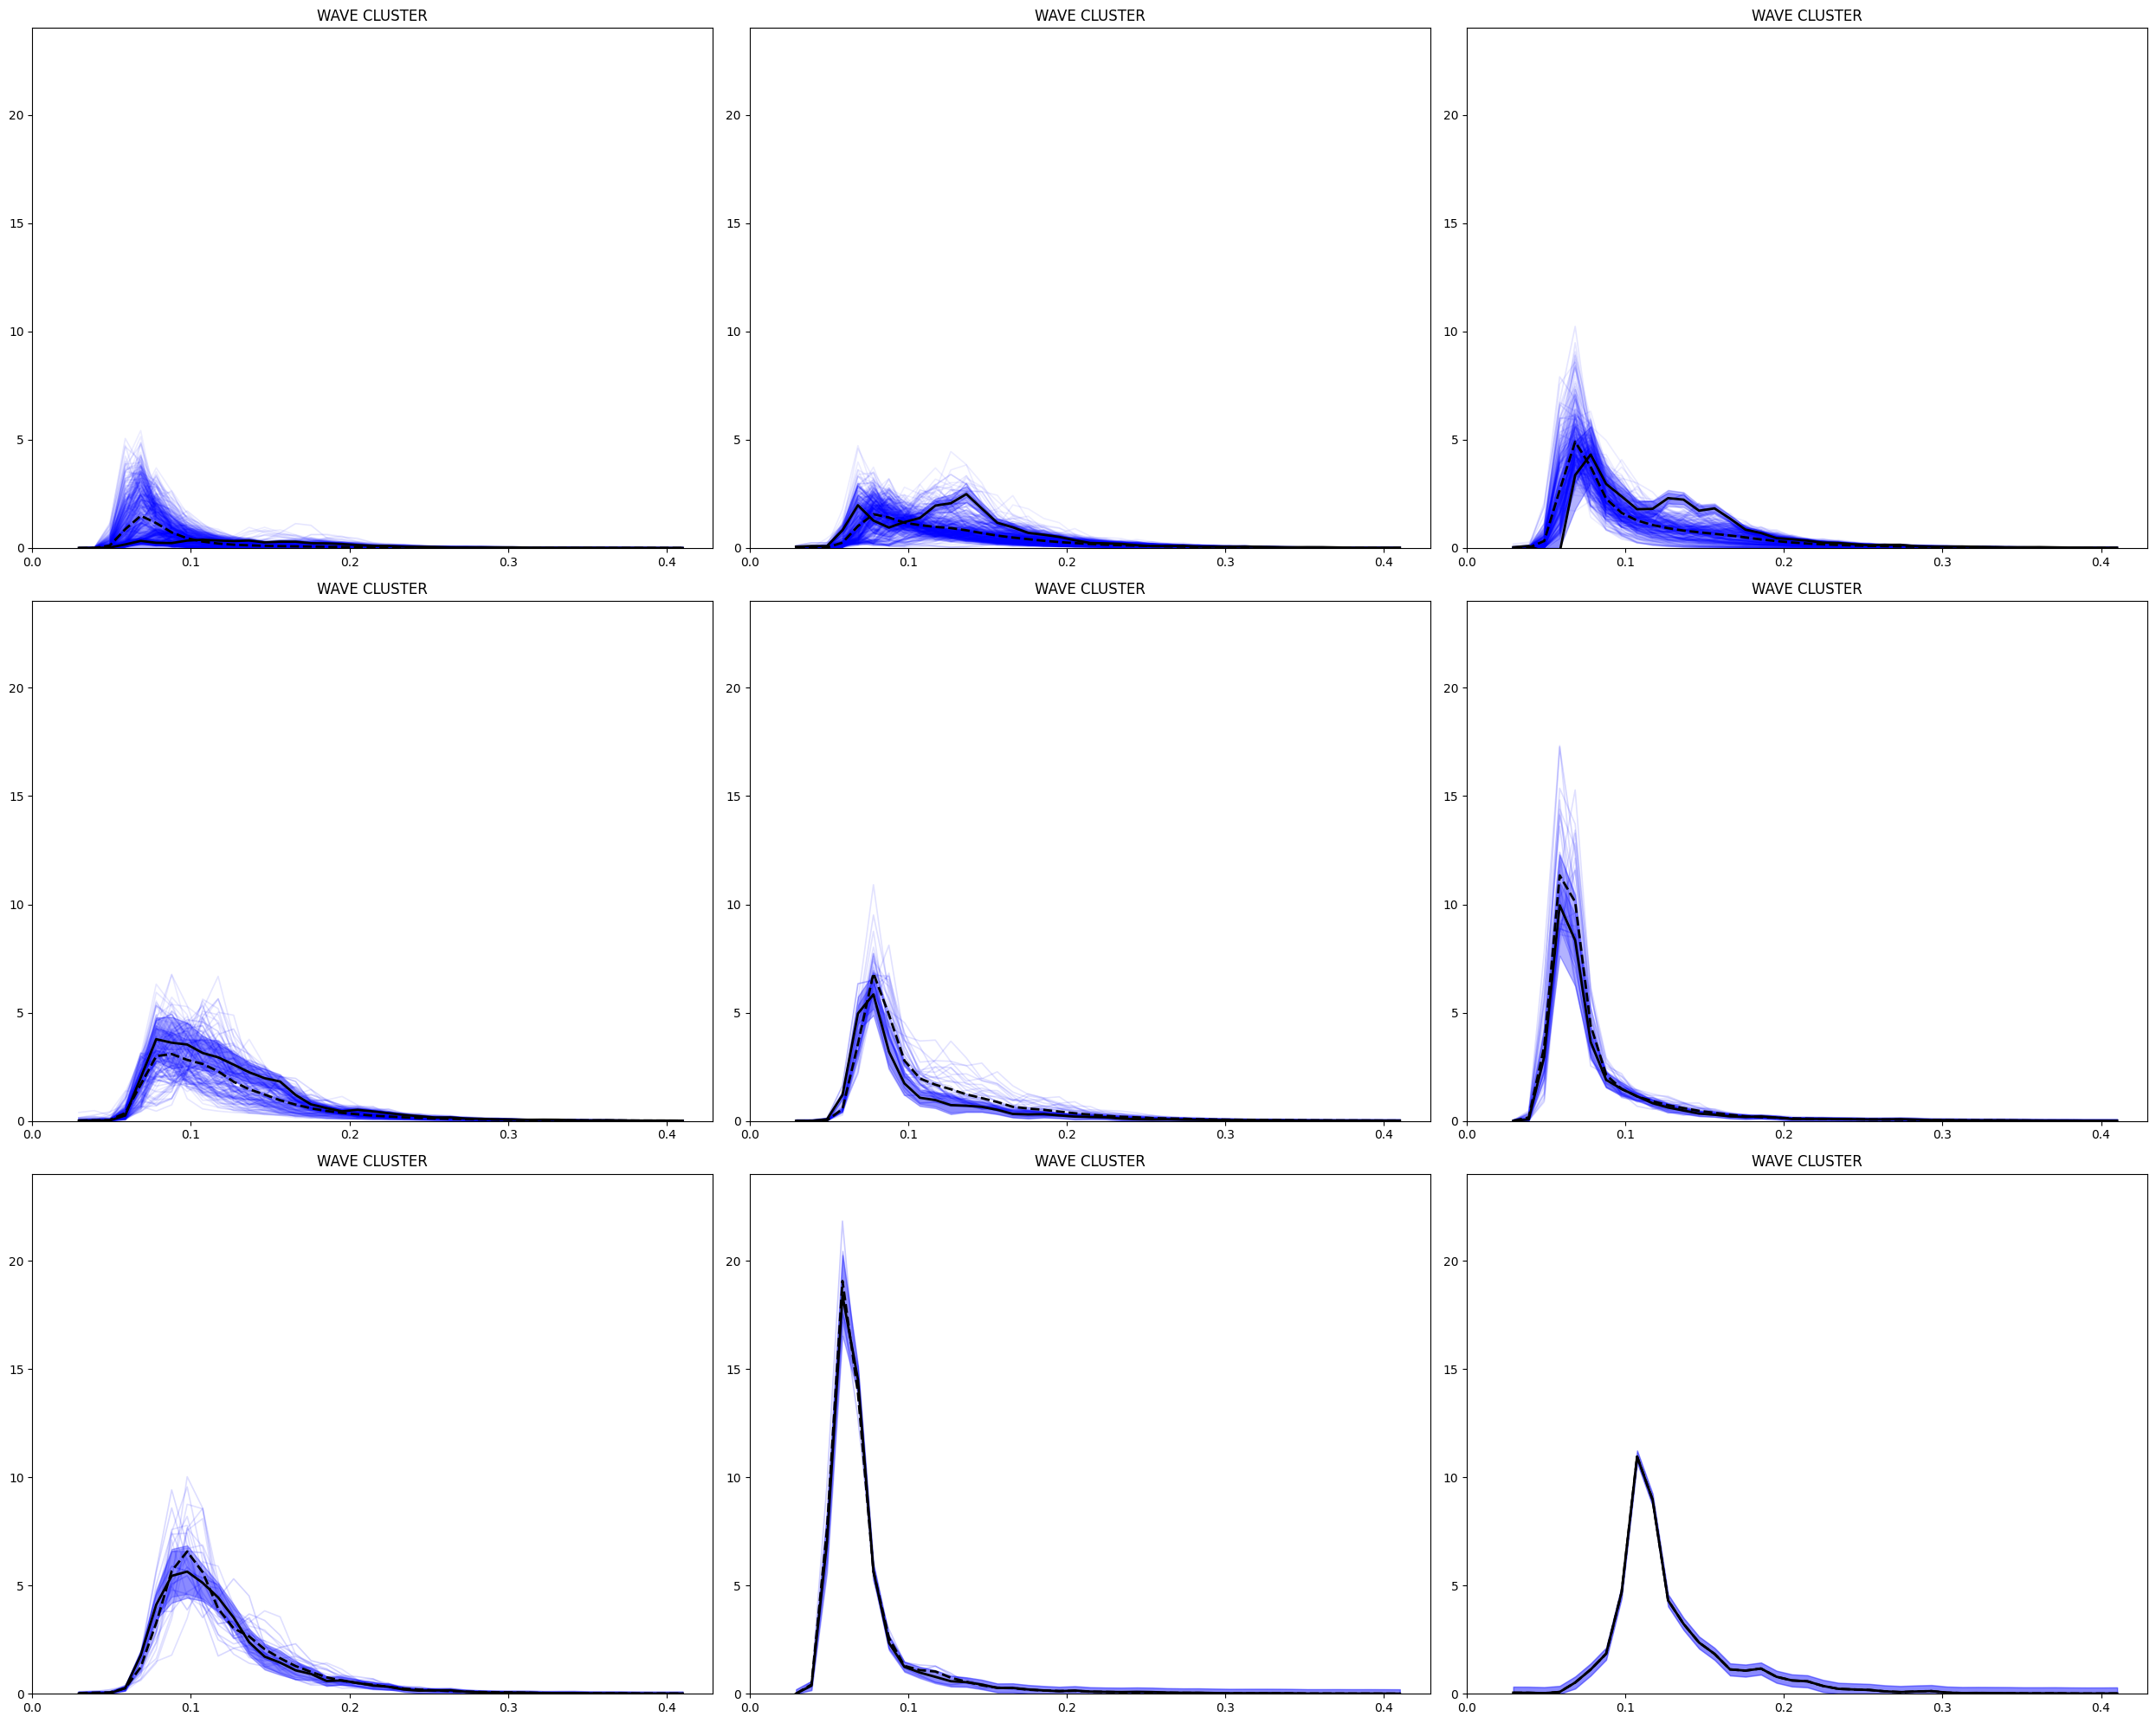

In [13]:
labels = np.array(['N'] * 6500)
cluster_labels_h = sw_gp_hillary.resp_assigned[-1].numpy()
np.save('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/cluster_labels/cluster_labels_hillary_202407.npy', cluster_labels_h)
main_model = print_results(sw_gp_hillary, labels, 0, error=False)
selected_gpmodels = sw_gp_hillary.selected_gpmodels()
up.plot_models_plotly(sw_gp_hillary, selected_gpmodels, main_model, labels, N_0=0, lead=1, step=(freq[1]-freq[0])/1,
                   plot_latent=False, title='WAVE CLUSTER',ticks=True, yscale=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_hillary.png")

Now with drifting 03.

In [14]:

cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'ocean', 'wawaves')
#f = h5py.File(os.path.join(data_path, 'Hillarys_202405.mat'), 'r')
f_drift03 = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting03_202407.mat'),'r')
print(f_drift03.get('SpotData').keys())
direction = np.array(f_drift03.get('SpotData/direction'))
variance_density = np.array(f_drift03.get('SpotData/varianceDensity'))
spec_time_drift03 = np.array(f_drift03.get('SpotData/spec_time'))
time = np.array(f_drift03.get('SpotData/time'))
frequency = np.array(f_drift03.get('SpotData/frequency'))
a1 = np.array(f_drift03.get('SpotData/a1'))
a2 = np.array(f_drift03.get('SpotData/a2'))
b1 = np.array(f_drift03.get('SpotData/b1'))
b2 = np.array(f_drift03.get('SpotData/b2'))
print("Shape of the data: ")
print(variance_density.shape)


<KeysViewHDF5 ['a1', 'a2', 'b1', 'b2', 'bott_temp', 'df', 'direction', 'directionalSpread', 'dm', 'dm_sea', 'dm_swell', 'dmspr', 'dmspr_sea', 'dmspr_swell', 'dp', 'dpspr', 'endFreq_sea', 'endFreq_swell', 'frequency', 'hsig', 'hsig_sea', 'hsig_swell', 'lat', 'lon', 'name', 'part_time', 'press_std_time', 'press_time', 'pressure', 'pressure_std', 'qf_bott_temp', 'qf_sst', 'qf_waves', 'serialID', 'spec_time', 'startFreq_sea', 'startFreq_swell', 'surf_temp', 'temp_time', 'time', 'tm', 'tm_sea', 'tm_swell', 'tp', 'varianceDensity', 'wind_dir', 'wind_seasurfaceId', 'wind_speed', 'wind_time']>
Shape of the data: 
(39, 297)


In [15]:
num_obs_per_sample, num_samples = variance_density.shape
S_theta = np.zeros((variance_density.shape[1], variance_density.shape[0], 37))
directions = np.deg2rad(np.linspace(0, 360.0, 37))
delta_theta = np.deg2rad(10.0)

In [16]:
for t in range(S_theta.shape[0]):
    for f in range(S_theta.shape[1]):
        # Load S(f), a1, b1, a2, b2 for this time and frequency
        S = variance_density[f, t]  # Omnidirectional spectrum
        a1_, b1_, a2_, b2_ = a1[f, t], b1[f, t], a2[f, t], b2[f, t]  # Directional moments
        if a1_ == -9999.0:
            a1_, b1_, a2_, b2_ = 0.0, 0.0, 0.0, 0.0
        for i, theta in enumerate(directions):
            # Compute D(f, theta)
            D = (1 / np.pi) * (
                    1 / 2 + (a1_ * np.cos(theta) + b1_ * np.sin(theta))
                    + (a2_ * np.cos(2 * theta) + b2_ * np.sin(2 * theta))
            )

            # Ensure non-negativity
            D = max(D, 0)

            # Compute S(f, theta)
            S_theta[t, f, i] = S * D

        # Optional: Renormalize to ensure sum(S_theta * delta_theta) ≈ S
        integral = np.sum(S_theta[t, f, :]) * delta_theta
        integral = integral if integral > 0 else 1.0
        S_theta[t, f, :] *= S / integral  # Adjust if integral != S


In [17]:
#Trying to transform data and direction to 3 dim data.
# direction_segments = np.floor(direction / 5.0).astype(np.int32)
# data_np = np.zeros((variance_density.shape[1], variance_density.shape[0], 73))
# for i, d in enumerate(data_np):
#     for t, dir in enumerate(direction_segments[:, i]):
#         d[t,dir] = d[t,dir] + variance_density[t, i]
dirs = np.linspace(0, 360.0, 37)
dirs = (dirs + 225.0) % 360.0
dataset = xr.Dataset(
    data_vars=dict(
        efth=(["time", "freq", "dir"], S_theta)
    ),
    coords=dict(
        time=(["time"], spec_time_drift03[0]),
        freq=(["freq"], frequency[:, 0]),
        dir=(["dir"], dirs)
    )
)
dts_drift03 = wv.SpecDataset(dataset)
new_dirs = np.linspace(0, 360, 37)  # Cada 10° incluyendo 360°
data_drifting03 = dts_drift03.interp(dir=new_dirs)
freq = data_drifting03.freq
data_drifting03 = data_drifting03.to_numpy()
freq_ = np.array(freq)

(297, 39, 37)
(39, 1)
Shape of hs: (297, 1)
How much spectra falls in the range 0.5-1.5 Hs: 297


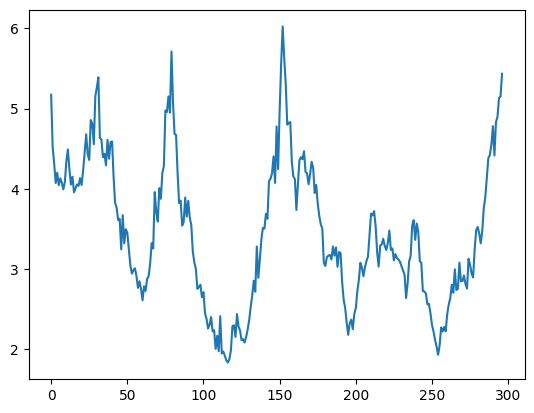

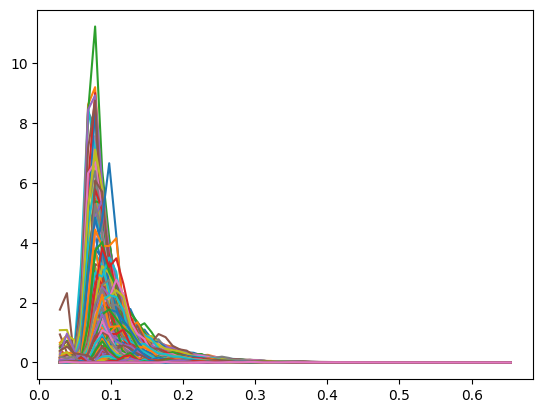

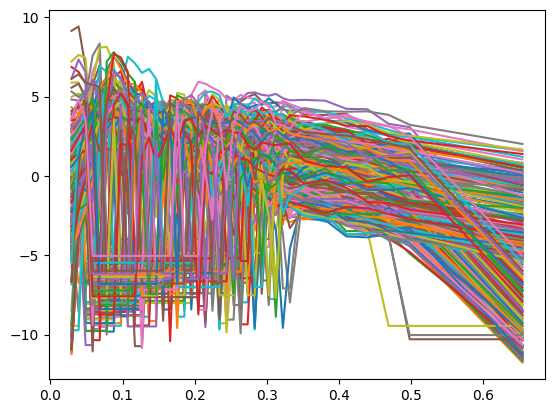

In [18]:
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq_[1] - freq_[0], num_obs_per_sample)[:, np.newaxis]
print(data_drifting03.shape)
print(interv.shape)
hs_d03 = 4 * np.sqrt(np.sum(data_drifting03, axis=2) * delta_theta @ interv)
print("Shape of hs: " + str(hs_d03.shape))
plt.plot(hs_d03)
chosen_indexes = np.where((hs_d03 > 0.5) & (hs_d03 < 1.5))[0]
chosen_indexes = np.arange(num_samples)
print("How much spectra falls in the range 0.5-1.5 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data_drifting03[:, :, 0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data_drifting03 + 1e-6) - np.mean(np.log(data_drifting03 + 1e-6), axis=1)[:, np.newaxis, :]
plt.plot(freq, lognorm_data[:, :, 0][chosen_indexes].T)
plt.show()

In [19]:
data_drifting03 = data_drifting03[chosen_indexes]
print("Shape of the data: ")
print(data_drifting03.shape)

num_samples, num_obs_per_sample, num_outputs = data_drifting03.shape
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data_drifting03, n_f=50, dim=25)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.3
std_dif = std_dif * 0.1
bound_sigma = (std * 1e-7, std * 1e-6)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-8)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 0.1
ini_lengthscale = 1e-3
bound_lengthscale = (1e-7, 5e-3)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
x_basis = np.atleast_2d(freq[0:40]).T
x_train = np.atleast_2d(freq[0:40]).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0] / 2.0, dtype=np.float64)).T

Shape of the data: 
(297, 39, 37)
Sigma estimated: 0.028108964019754983
Gamma estimated: 0.028108964019754983
Final sigma: 0.008432689205926495
Final gamma: 0.0028108964019754983
Final sigma bound: (8.432689205926494e-10, 8.432689205926495e-09)
Final gamma bound: (np.float64(2.8108964019754984e-12), np.float64(2.8108964019754983e-11))
(39, 1)


In [20]:
sw_gp_drift03 = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=36,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=15, free_deg_MNIV=8, share_gp=True, use_snr=False, reduce_outputs=True, reduce_outputs_ratio=0.2)

num_samples = data_drifting03.shape[0]
#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp_drift03.include_batch(x_trains, data_drifting03[:,0:40,:])

------ HDP Hyperparameters ------
gamma: 0.8
transAlpha: 0.8
startAlpha: 0.8
kappa: 0.0
---------------------------------
Performed reduction of outputs based on variance.
Ratio of reduction: 0.2 Final outputs: [23 24 25 26 27 28 29]
Group responsability estimated: [297]
---Kernel estimated---
1.7**2 * RBF(length_scale=0.0136) + WhiteKernel(noise_level=7.87e-09)
Step 1/15- Trying to divide: 0 with beat 102
Sum resp_temp: [252  45]
Q_em: -15540.71, Q_lat: -42631.86, Elbo_linear: -75.24, Elbo_LDS: -1069.15
>>> Q_all_loop -------
Sum resp_temp: [252  45]
Q_em: -15540.71, Q_lat: -42631.86, Elbo_linear: -75.24, Elbo_LDS: -1069.15
Sum resp_temp: [253  44]
Q_em: -15484.85, Q_lat: -42042.23, Elbo_linear: -60.13, Elbo_LDS: -1066.73
Sum resp_temp: [253  44]
Q_em: -15484.85, Q_lat: -42042.23, Elbo_linear: -60.13, Elbo_LDS: -1066.73
ELBO_reduction: 663.0270546335596
>>> Q_all_loop -------
Sum resp_temp: [253  44]
Q_em: -15484.85, Q_lat: -42042.23, Elbo_linear: -60.13, Elbo_LDS: -1066.73
Sum resp_t

Model 1 : MainModel: N : [N-103]
Model 2 : MainModel: N : [N-62]
Model 3 : MainModel: N : [N-33]
Model 4 : MainModel: N : [N-24]
Model 5 : MainModel: N : [N-17]
Model 6 : MainModel: N : [N-14]
Model 7 : MainModel: N : [N-13]
Model 8 : MainModel: N : [N-12]
Model 9 : MainModel: N : [N-8]
Model 10 : MainModel: N : [N-4]
Model 11 : MainModel: N : [N-3]
Model 12 : MainModel: N : [N-2]
Model 13 : MainModel: N : [N-1]
Model 14 : MainModel: N : [N-1]
Classification error: 0 / 297 -- 0.00000


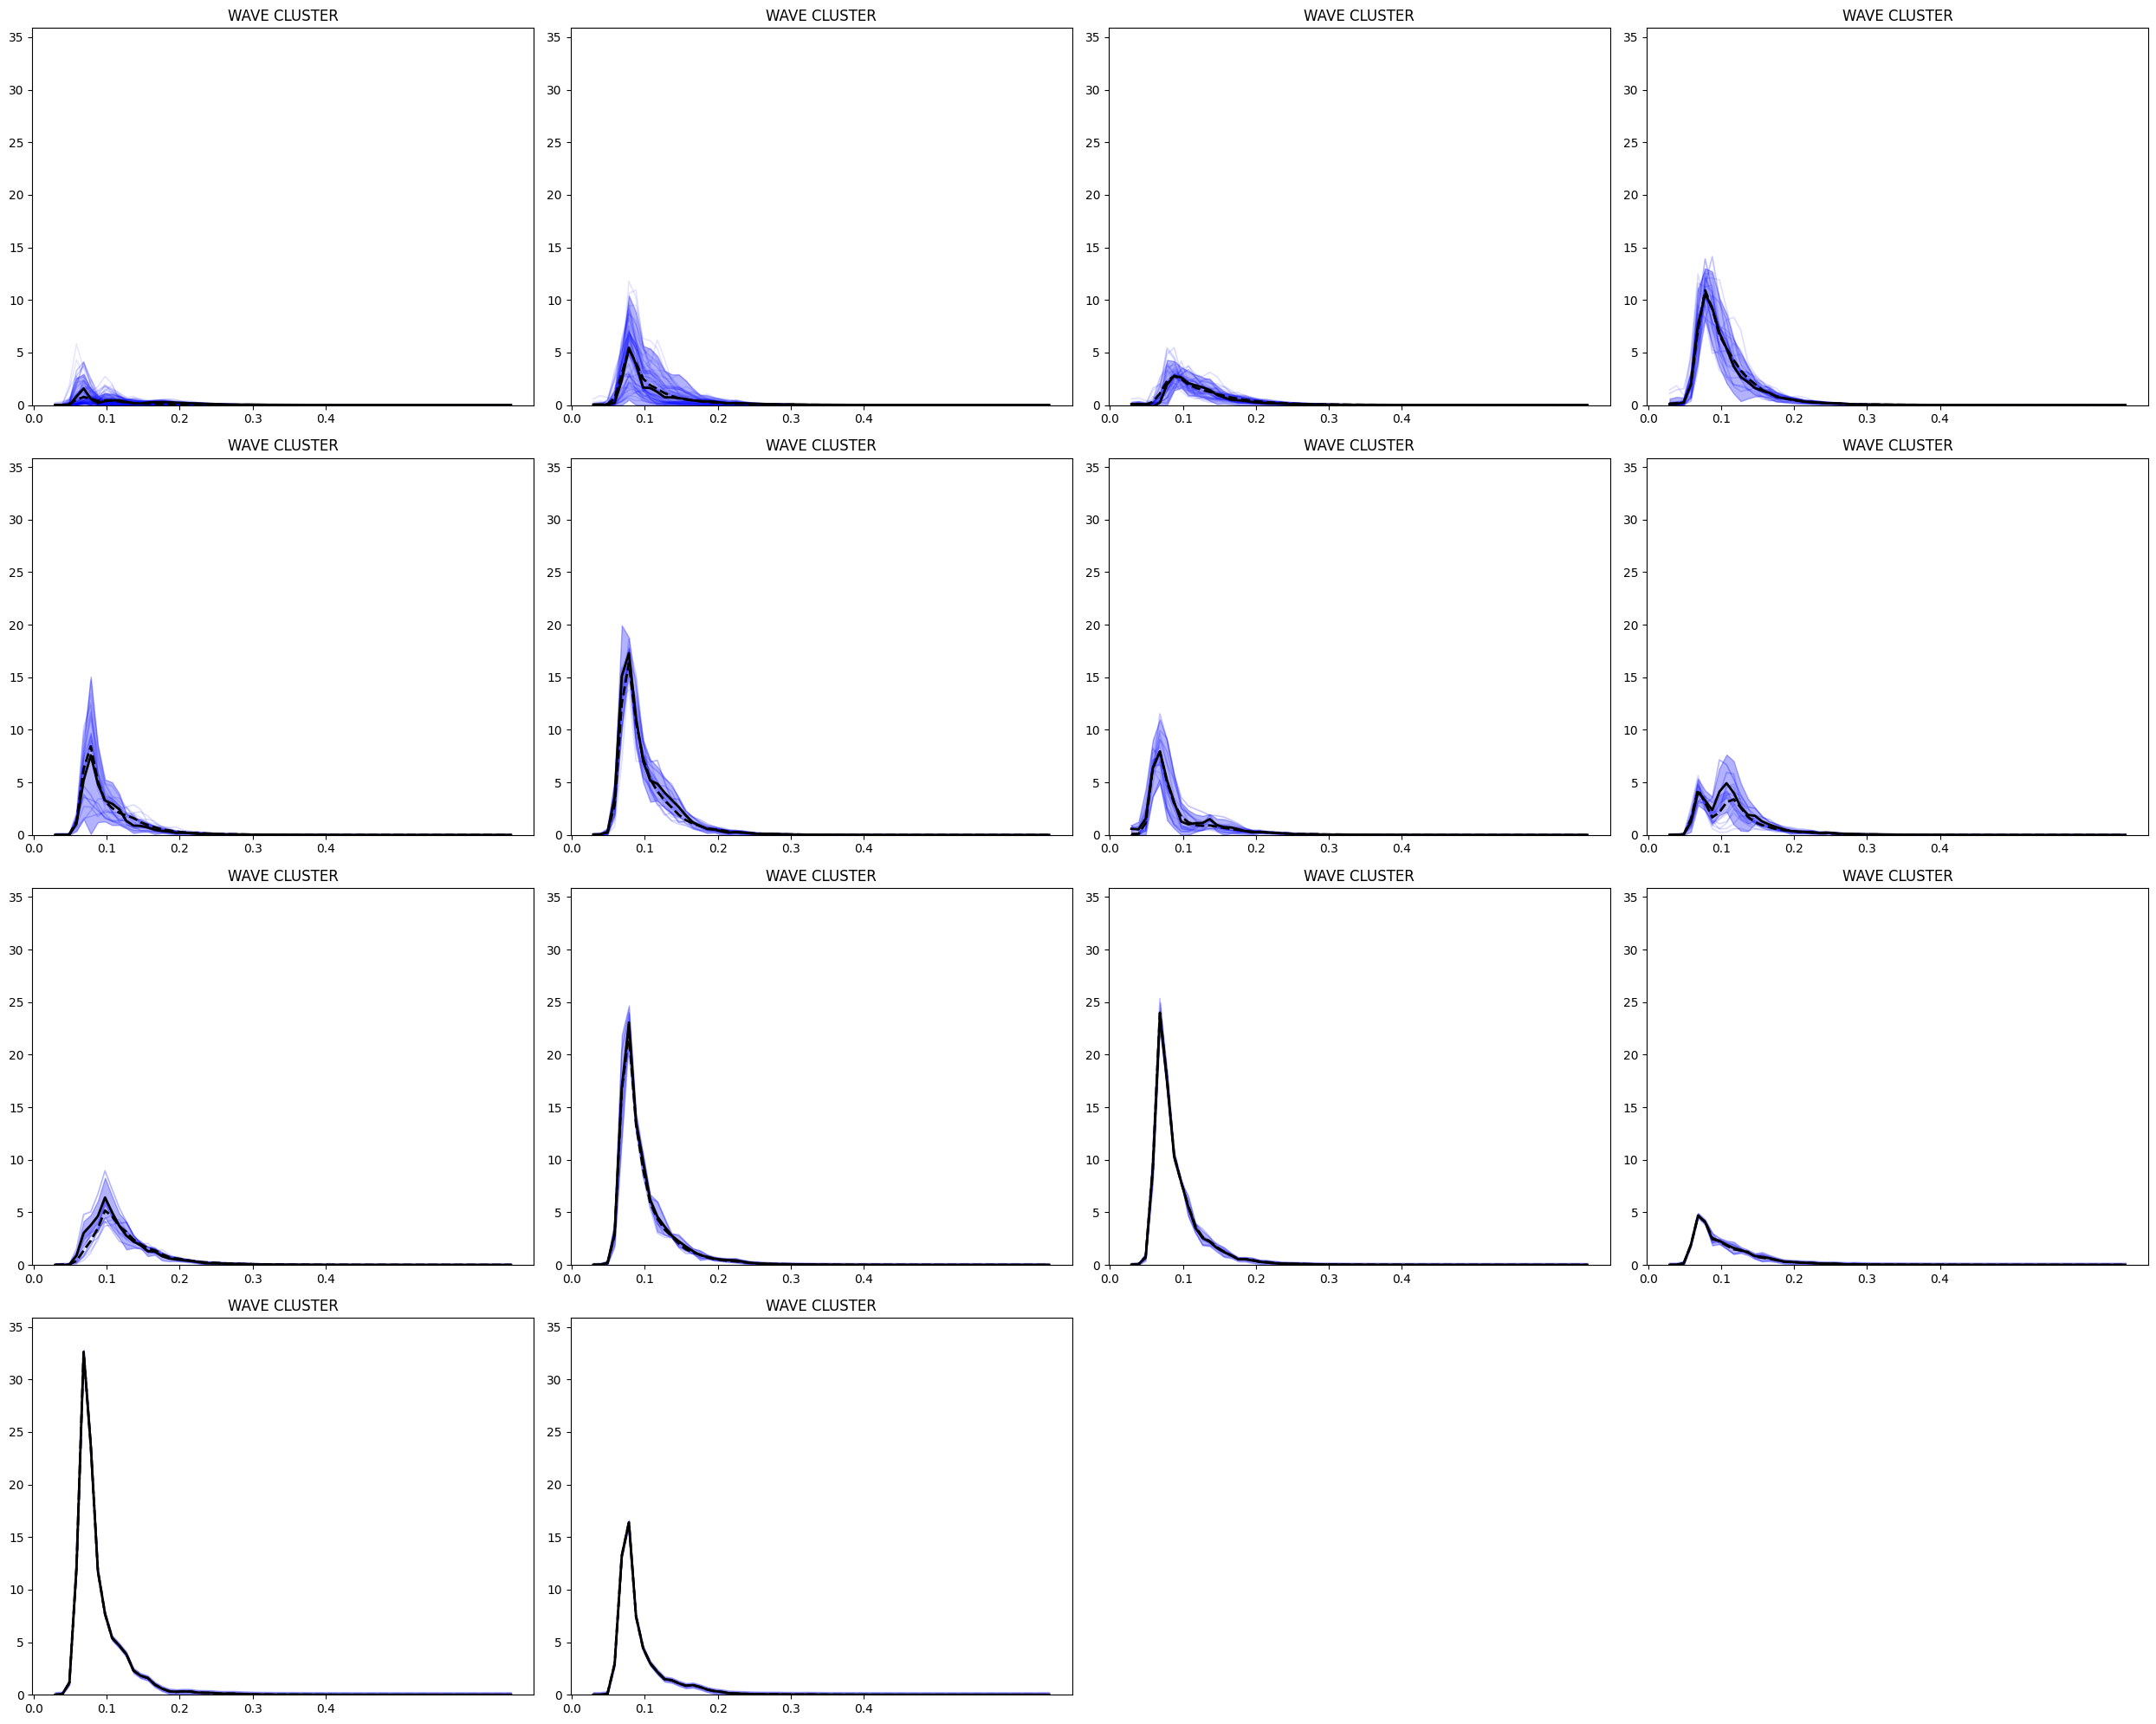

In [21]:
labels = np.array(['N'] * 6500)
cluster_labels_d03 = sw_gp_drift03.resp_assigned[-1].numpy()
np.save('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/cluster_labels/cluster_labels_drift03_202407.npy', cluster_labels_d03)
main_model = print_results(sw_gp_drift03, labels, 0, error=False)
selected_gpmodels = sw_gp_drift03.selected_gpmodels()
up.plot_models_plotly(sw_gp_drift03, selected_gpmodels, main_model, labels, N_0=0, lead=1, step=(freq[1]-freq[0])/1,
                   plot_latent=False, title='WAVE CLUSTER',ticks=True, yscale=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_drift03.png")

Now with drifting 06.

In [22]:

cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'ocean', 'wawaves')
#f = h5py.File(os.path.join(data_path, 'Hillarys_202405.mat'), 'r')
f_drift06 = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting08_202407.mat'), 'r')
print(f_drift06.get('SpotData').keys())
direction = np.array(f_drift06.get('SpotData/direction'))
variance_density = np.array(f_drift06.get('SpotData/varianceDensity'))
spec_time_drift06 = np.array(f_drift06.get('SpotData/spec_time'))
time = np.array(f_drift06.get('SpotData/time'))
frequency = np.array(f_drift06.get('SpotData/frequency'))
a1 = np.array(f_drift06.get('SpotData/a1'))
a2 = np.array(f_drift06.get('SpotData/a2'))
b1 = np.array(f_drift06.get('SpotData/b1'))
b2 = np.array(f_drift06.get('SpotData/b2'))
print("Shape of the data: ")
print(variance_density.shape)

<KeysViewHDF5 ['a1', 'a2', 'b1', 'b2', 'bott_temp', 'df', 'direction', 'directionalSpread', 'dm', 'dm_sea', 'dm_swell', 'dmspr', 'dmspr_sea', 'dmspr_swell', 'dp', 'dpspr', 'endFreq_sea', 'endFreq_swell', 'frequency', 'hsig', 'hsig_sea', 'hsig_swell', 'lat', 'lon', 'name', 'part_time', 'press_std_time', 'press_time', 'pressure', 'pressure_std', 'qf_bott_temp', 'qf_sst', 'qf_waves', 'serialID', 'spec_time', 'startFreq_sea', 'startFreq_swell', 'surf_temp', 'temp_time', 'time', 'tm', 'tm_sea', 'tm_swell', 'tp', 'varianceDensity', 'wind_dir', 'wind_seasurfaceId', 'wind_speed', 'wind_time']>
Shape of the data: 
(39, 374)


In [23]:

num_obs_per_sample, num_samples = variance_density.shape
S_theta = np.zeros((variance_density.shape[1], variance_density.shape[0], 37))
directions = np.deg2rad(np.linspace(0, 360.0, 37))
delta_theta = np.deg2rad(10.0)
for t in range(S_theta.shape[0]):
    for f in range(S_theta.shape[1]):
        # Load S(f), a1, b1, a2, b2 for this time and frequency
        S = variance_density[f, t]  # Omnidirectional spectrum
        a1_, b1_, a2_, b2_ = a1[f, t], b1[f, t], a2[f, t], b2[f, t]  # Directional moments

        for i, theta in enumerate(directions):
            # Compute D(f, theta)
            D = (1 / np.pi) * (
                    1 / 2 + (a1_ * np.cos(theta) + b1_ * np.sin(theta))
                    + (a2_ * np.cos(2 * theta) + b2_ * np.sin(2 * theta))
            )

            # Ensure non-negativity
            D = max(D, 0)

            # Compute S(f, theta)
            S_theta[t, f, i] = S * D

        # Optional: Renormalize to ensure sum(S_theta * delta_theta) ≈ S
        integral = np.sum(S_theta[t, f, :]) * delta_theta
        integral = integral if integral > 0 else 1.0
        S_theta[t, f, :] *= S / integral  # Adjust if integral != S

Shape of hs: (374, 1)
How much spectra falls in the range 0.5-1.5 Hs: 374


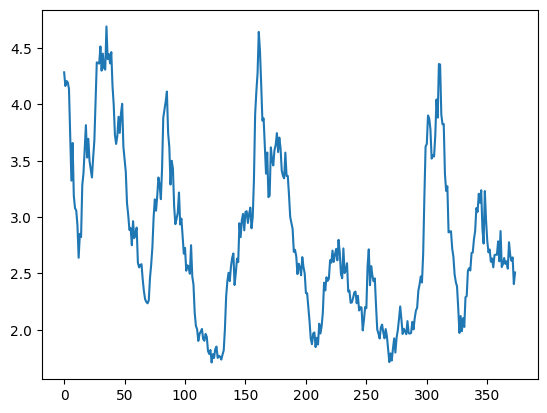

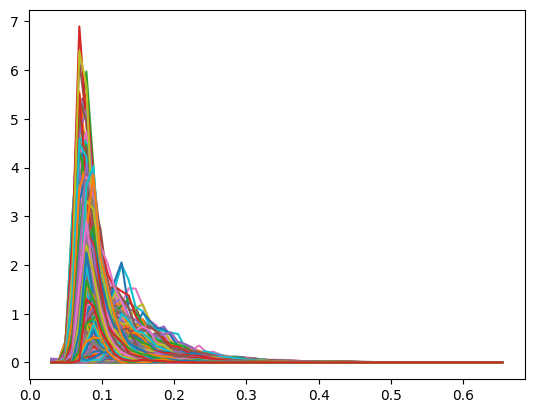

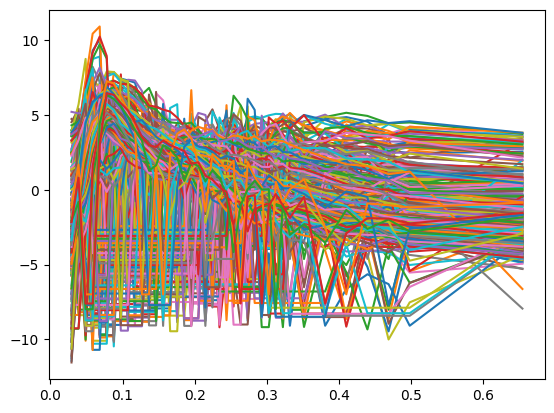

Shape of the data: 
(374, 39, 37)
Sigma estimated: 0.9305767928570265
Gamma estimated: 0.9305767928570265
Final sigma: 0.027917303785710796
Final gamma: 0.009305767928570265
Final sigma bound: (2.7917303785710793e-09, 2.7917303785710794e-08)
Final gamma bound: (np.float64(9.305767928570265e-12), np.float64(9.305767928570265e-11))


In [24]:

#Trying to transform data and direction to 3 dim data.
# direction_segments = np.floor(direction / 5.0).astype(np.int32)
# data_np = np.zeros((variance_density.shape[1], variance_density.shape[0], 73))
# for i, d in enumerate(data_np):
#     for t, dir in enumerate(direction_segments[:, i]):
#         d[t,dir] = d[t,dir] + variance_density[t, i]
dirs = np.linspace(0, 360.0, 37)
dirs = (dirs + 225.0) % 360.0
dataset = xr.Dataset(
    data_vars=dict(
        efth=(["time", "freq", "dir"], S_theta)
    ),
    coords=dict(
        time=(["time"], spec_time_drift06[0]),
        freq=(["freq"], frequency[:, 0]),
        dir=(["dir"], dirs)
    )
)
dts_drift06 = wv.SpecDataset(dataset)
new_dirs = np.linspace(0, 360, 37)  # Cada 10° incluyendo 360°
data_drifting06 = dts_drift06.interp(dir=new_dirs)
freq = data_drifting06.freq
data_drifting06 = data_drifting06.to_numpy()
freq_ = np.array(freq)
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq_[1] - freq_[0], num_obs_per_sample)[:, np.newaxis]
hs_d06 = 4 * np.sqrt(np.sum(data_drifting06, axis=2) * delta_theta @ interv)
print("Shape of hs: " + str(hs_d06.shape))
plt.plot(hs_d06)
chosen_indexes = np.where((hs_d06 > 0.5) & (hs_d06 < 1.5))[0]
chosen_indexes = np.arange(num_samples)
print("How much spectra falls in the range 0.5-1.5 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data_drifting06[:, :, 0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data_drifting06 + 1e-6) - np.mean(np.log(data_drifting06 + 1e-6), axis=1)[:, np.newaxis, :]
plt.plot(freq, lognorm_data[:, :, 0][chosen_indexes].T)
plt.show()
data_drifting06 = data_drifting06[chosen_indexes]
print("Shape of the data: ")
print(data_drifting06.shape)

num_samples, num_obs_per_sample, num_outputs = data_drifting06.shape
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data_drifting06, n_f=50, dim=25)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.03
std_dif = std_dif * 0.01
bound_sigma = (std * 1e-7, std * 1e-6)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-8)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

(39, 1)
------ HDP Hyperparameters ------
gamma: 0.8
transAlpha: 0.8
startAlpha: 0.8
kappa: 0.0
---------------------------------
Performed reduction of outputs based on variance.
Ratio of reduction: 0.2 Final outputs: [24 25 26 27 28 29 30]
Group responsability estimated: [374]
---Kernel estimated---
1.71**2 * RBF(length_scale=0.0135) + WhiteKernel(noise_level=2.6e-08)
Step 1/15- Trying to divide: 0 with beat 213
Sum resp_temp: [307  67]
Q_em: -16155.53, Q_lat: -34854.31, Elbo_linear: -82.36, Elbo_LDS: -1706.22
>>> Q_all_loop -------
Sum resp_temp: [307  67]
Q_em: -16155.53, Q_lat: -34854.31, Elbo_linear: -82.36, Elbo_LDS: -1706.22
Sum resp_temp: [306  68]
Q_em: -16145.66, Q_lat: -34821.03, Elbo_linear: -59.89, Elbo_LDS: -1706.66
Sum resp_temp: [306  68]
Q_em: -16145.66, Q_lat: -34821.03, Elbo_linear: -59.89, Elbo_LDS: -1706.66
ELBO_reduction: 65.18961652026337
>>> Q_all_loop -------
Sum resp_temp: [306  68]
Q_em: -16145.66, Q_lat: -34821.03, Elbo_linear: -59.89, Elbo_LDS: -1706.66
Su

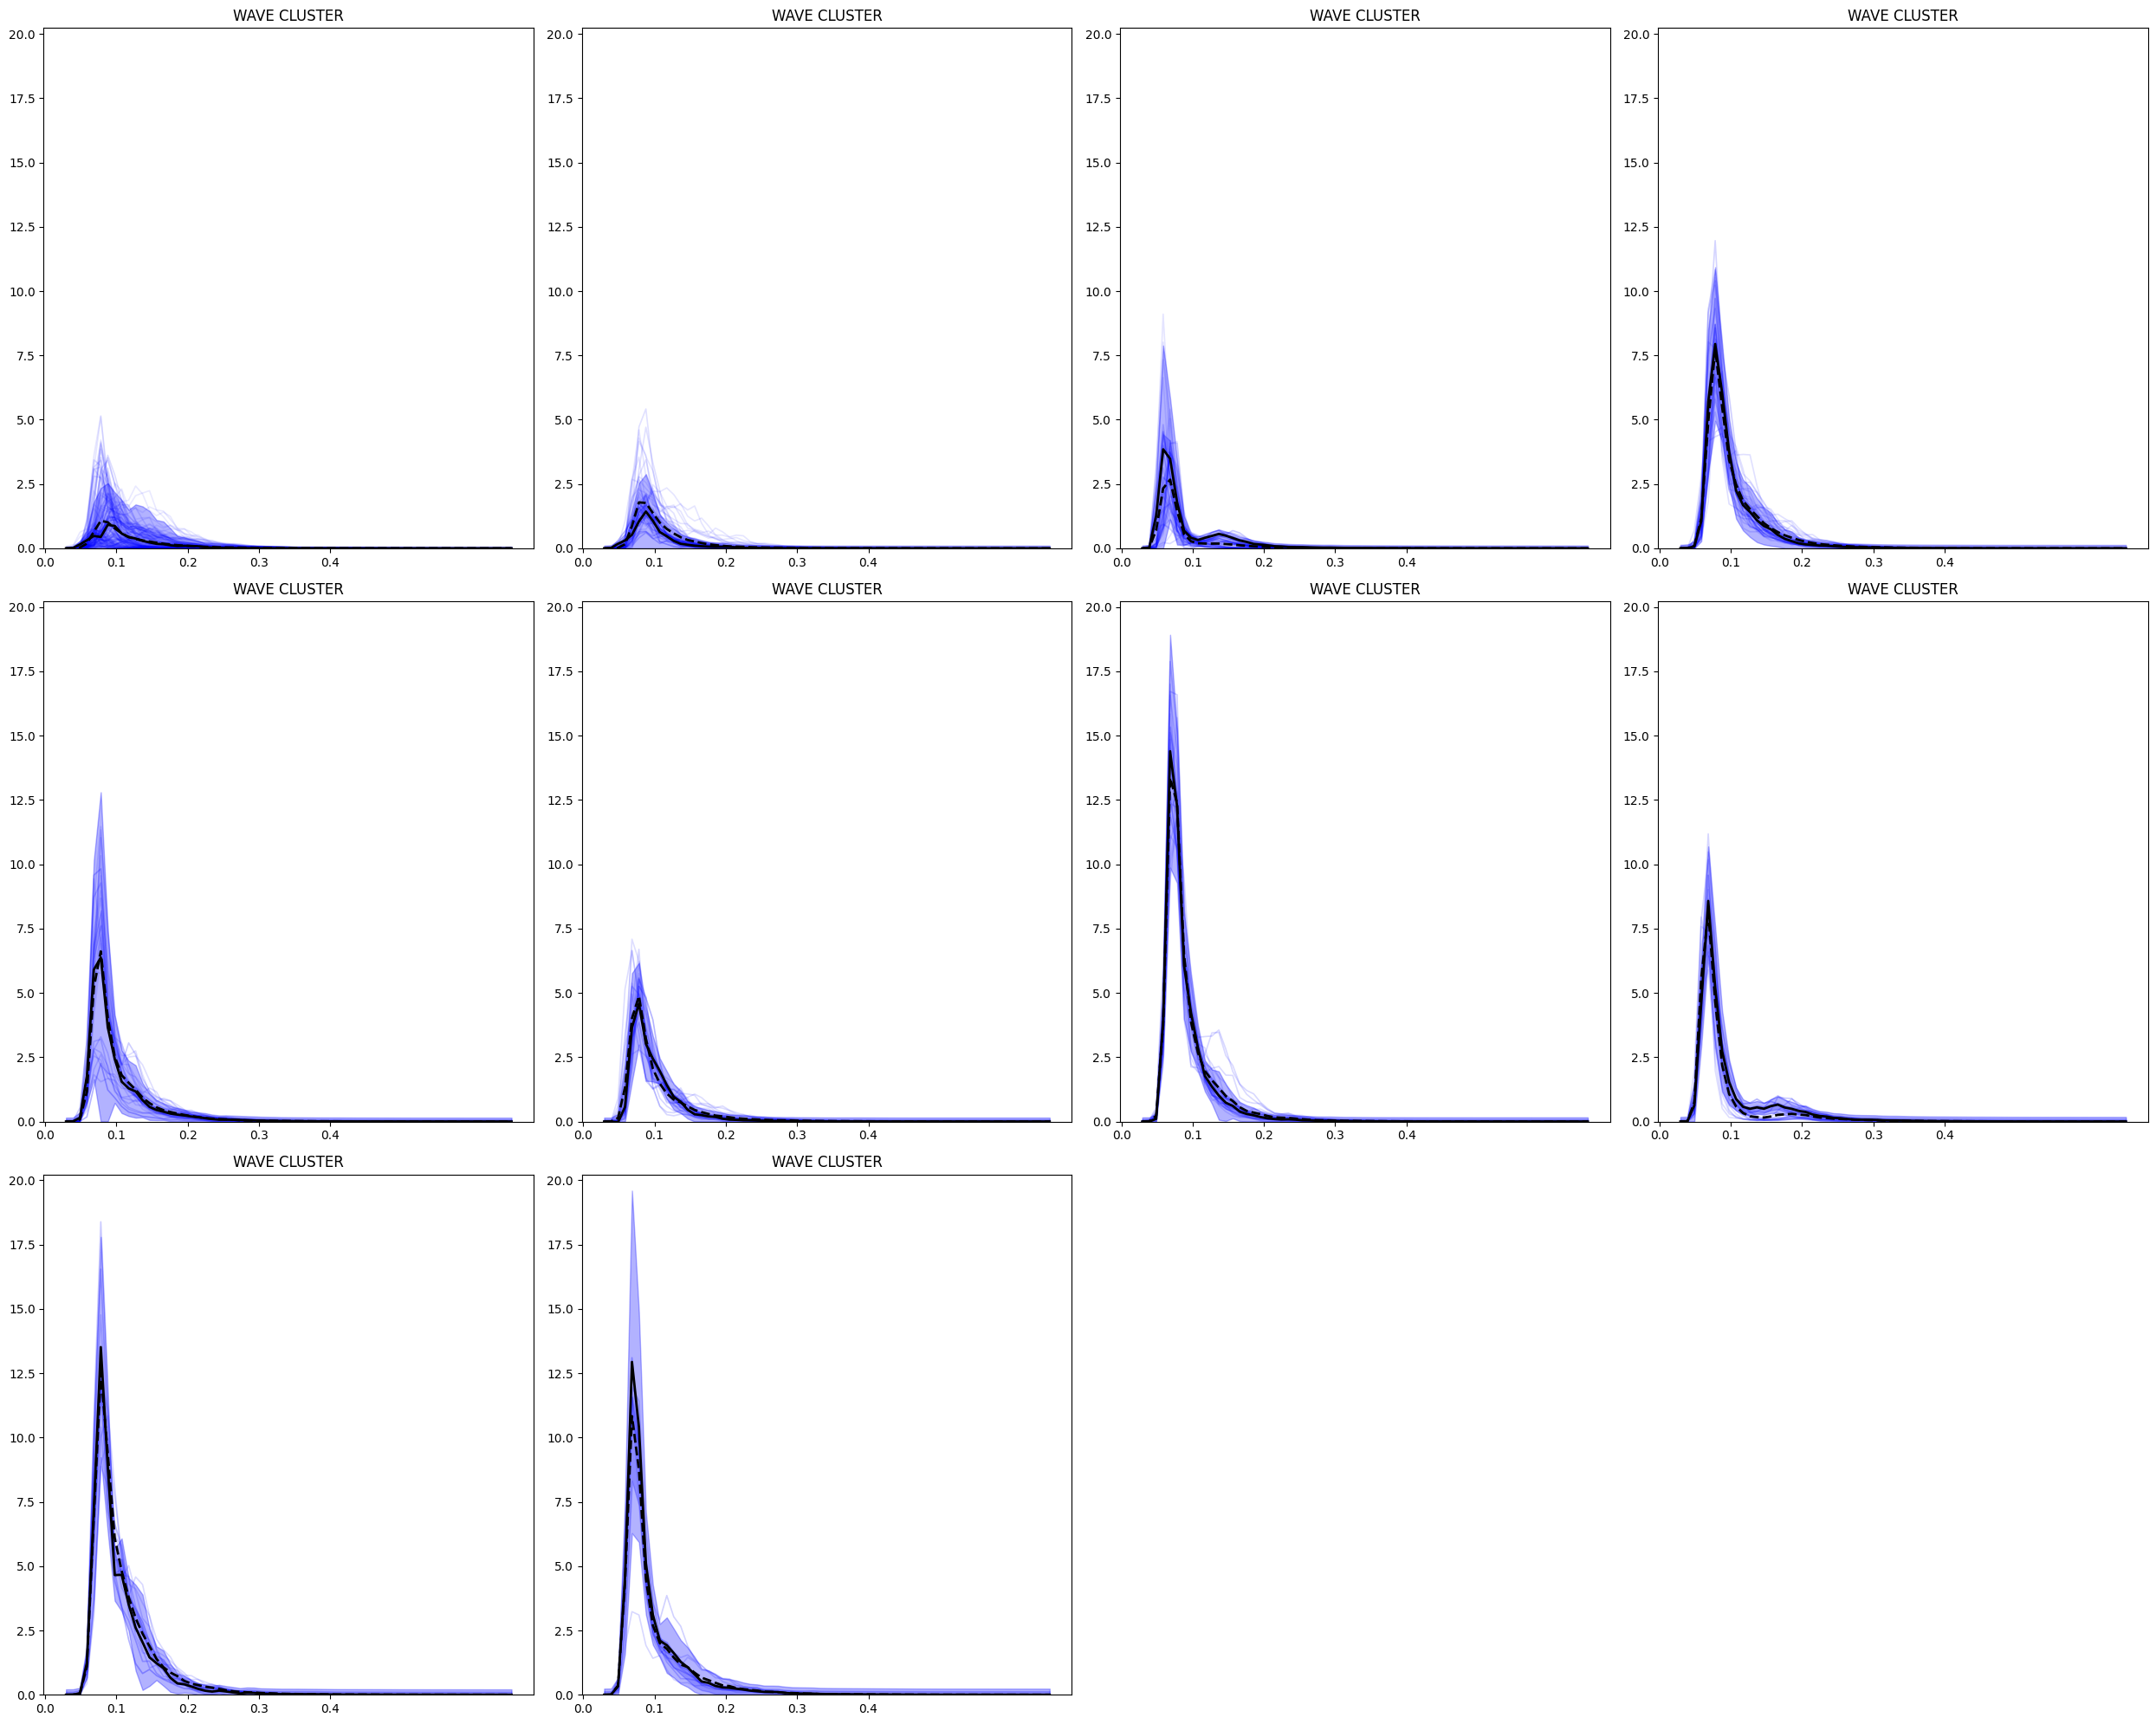

In [25]:

M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 0.1
ini_lengthscale = 1e-3
bound_lengthscale = (1e-7, 5e-3)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
x_basis = np.atleast_2d(freq[0:40]).T
x_train = np.atleast_2d(freq[0:40]).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0] / 2.0, dtype=np.float64)).T
sw_gp_drift06 = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=36,
                              ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                              ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                              bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                              verbose=False, max_models=100, inducing_points=inducing_points,
                              reestimate_initial_params=False,
                              n_explore_steps=15, free_deg_MNIV=8, share_gp=True, use_snr=False, reduce_outputs=True,
                              reduce_outputs_ratio=0.2)

num_samples = data_drifting06.shape[0]
#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp_drift06.include_batch(x_trains, data_drifting06[:, 0:40, :])
labels = np.array(['N'] * 6500)
cluster_labels_d08 = sw_gp_drift06.resp_assigned[-1].numpy()
np.save('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/cluster_labels/cluster_labels_drift08_202407.npy', cluster_labels_d08)
main_model = print_results(sw_gp_drift06, labels, 0, error=False)
selected_gpmodels = sw_gp_drift06.selected_gpmodels()
up.plot_models_plotly(sw_gp_drift06, selected_gpmodels, main_model, labels, N_0=0, lead=1, step=(freq[1] - freq[0]) / 1,
                      plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True,
                      save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_drift06.png")

In [26]:
print(spec_time_drift03.shape)
from datetime import datetime, timedelta

def matlab_datenum_to_datetime(matlab_datenum):
    """
    Convert MATLAB datenum to Python datetime.
    """
    days = int(matlab_datenum)
    frac = matlab_datenum % 1
    python_datetime = datetime.fromordinal(days - 366) + timedelta(days=frac)
    return python_datetime

data_time_drift03 = [matlab_datenum_to_datetime(t) for t in spec_time_drift03[0]]
data_time_drift06 = [matlab_datenum_to_datetime(t) for t in spec_time_drift06[0]]
data_time_hillarys = [matlab_datenum_to_datetime(t) for t in spec_time_hillarys[0]]
print(np.min(data_time_hillarys), np.max(data_time_hillarys))
print(np.min(data_time_drift03), np.max(data_time_drift03))
print(np.min(data_time_drift06), np.max(data_time_drift06))


(1, 297)
2024-07-01 00:00:00 2024-07-31 23:29:59.999997
2024-07-01 00:02:30.999996 2024-07-25 18:02:30.999996
2024-07-01 00:14:59.999997 2024-07-31 23:29:59.999997


# Gráfica distribución por meses y clusters

In [28]:
df_hillarys = pd.DataFrame({
    'time': data_time_hillarys,
    'cluster': sw_gp_hillary.resp_assigned[-1]
})

# Crear columna cos días do ano (usado como eixo X)
df_hillarys['min'] = df_hillarys['time'].dt.minute
df_hillarys['hour'] = df_hillarys['time'].dt.hour
df_hillarys['day'] = df_hillarys['time'].dt.dayofyear  # Día do ano (1-365)
df_hillarys['month'] = df_hillarys['time'].dt.month    # Para ticks e estética
df_hillarys['date'] = df_hillarys['time'].dt.date

df_drift03 = pd.DataFrame({
    'time': data_time_drift03,
    'cluster': sw_gp_drift03.resp_assigned[-1]
})

# Crear columna cos días do ano (usado como eixo X)
df_drift03['min'] = df_drift03['time'].dt.minute
df_drift03['hour'] = df_drift03['time'].dt.hour
df_drift03['day'] = df_drift03['time'].dt.dayofyear  # Día do ano (1-365)
df_drift03['month'] = df_drift03['time'].dt.month    # Para ticks e estética
df_drift03['date'] = df_drift03['time'].dt.date  # Por se queres filtrar por data concreta


df_drift06 = pd.DataFrame({
    'time': data_time_drift06,
    'cluster': sw_gp_drift06.resp_assigned[-1]
})

# Crear columna cos días do ano (usado como eixo X)
df_drift06['min'] = df_drift06['time'].dt.minute
df_drift06['hour'] = df_drift06['time'].dt.hour
df_drift06['day'] = df_drift06['time'].dt.dayofyear  # Día do ano (1-365)
df_drift06['month'] = df_drift06['time'].dt.month    # Para ticks e estética
df_drift06['date'] = df_drift06['time'].dt.date

frequencies_hillarys = freq_hillarys
directions_hillarys = np.rad2deg(directions)
energy_spectral = data
tensors_list_hillarys = []
for gp in sw_gp_hillary.gpmodels[0]:
    subdata = np.mean(data[gp.indexes], axis=0)
    tensors_list_hillarys.append(subdata)

frequencies_drift03 = freq
directions_drift03 = np.rad2deg(directions)
energy_spectral = data_drifting03
tensors_list_drift03 = []
for gp in sw_gp_drift03.gpmodels[0]:
    subdata = np.mean(data_drifting03[gp.indexes], axis=0)
    tensors_list_drift03.append(subdata)

frequencies_drift06 = freq
directions_drift06 = np.rad2deg(directions)
energy_spectral = data_drifting06
tensors_list_drift06 = []
for gp in sw_gp_drift06.gpmodels[0][:-1]:
    subdata = np.mean(data_drifting06[gp.indexes], axis=0)
    tensors_list_drift06.append(subdata)

clust_h, indexes_h = np.unique(sw_gp_hillary.resp_assigned[-1], return_index=True)

clust_d, indexes_d = np.unique(sw_gp_drift03.resp_assigned[-1], return_index=True)

clust_d6, indexes_d = np.unique(sw_gp_drift06.resp_assigned[-1], return_index=True)

tensors_list_hillarys = np.array(tensors_list_hillarys)
tensors_list_drift03 = np.array(tensors_list_drift03)
tensors_list_drift06 = np.array(tensors_list_drift06)

n_clusters_hillarys = clust_h.shape[0]
n_clusters_drift03 = clust_d.shape[0]
n_clusters_drift06 = clust_d6.shape[0]

ds_cluster_means_hillarys = xr.Dataset(
    data_vars=dict(
        efth=(["cluster", "freq", "dir"], tensors_list_hillarys),
    ),
    coords=dict(
        cluster=(["cluster"], clust_h),
        freq=(["freq"], frequencies_hillarys.to_numpy()),
        dir=(["dir"], directions_hillarys)
))

ds_cluster_means_drift03 = xr.Dataset(
    data_vars=dict(
        efth=(["cluster", "freq", "dir"], tensors_list_drift03),
    ),
    coords=dict(
        cluster=(["cluster"], clust_d),
        freq=(["freq"], frequencies_drift03.to_numpy()),
        dir=(["dir"], directions_drift03)
))

ds_cluster_means_drift06 = xr.Dataset(
    data_vars=dict(
        efth=(["cluster", "freq", "dir"], tensors_list_drift06),
    ),
    coords=dict(
        cluster=(["cluster"], clust_d6),
        freq=(["freq"], frequencies_drift06.to_numpy()),
        dir=(["dir"], directions_drift06)
))

efth_ordered_hillarys = ds_cluster_means_hillarys['efth'].transpose('cluster', 'dir', 'freq')

efth_ordered_drift03 = ds_cluster_means_drift03['efth'].transpose('cluster', 'dir', 'freq')

efth_ordered_drift06 = ds_cluster_means_drift06['efth'].transpose('cluster', 'dir', 'freq')


In [38]:

gp_b = sw_gp_hillary.gpmodels[0][0]
x_bas = gp_b.x_basis
dist_clusters_hillarys = []
dist_clusters_drift03 = []
dist_clusters_drift06 = []
order='sum_energy'
##Order of clusters from similar to disimilar with respect to Hillarys 0.
if order == 'KL_similarity':
    for i in range(n_clusters_hillarys):
        dist = 0
        for j in range(sw_gp_hillary.n_outputs):
            gp_b = sw_gp_hillary.gpmodels[j][0]
            gp = sw_gp_hillary.gpmodels[j][i]
            x_bas = gp.x_basis
            dist = dist + gp_b.KL_divergence(len(gp_b.indexes)-1, gp,len(gp.indexes)-1, x_bas=x_bas)
        dist_clusters_hillarys.append(dist)
    for i in range(n_clusters_drift03):
        dist = 0
        for j in range(sw_gp_hillary.n_outputs):
            gp_b = sw_gp_hillary.gpmodels[j][0]
            gp = sw_gp_drift03.gpmodels[j][i]
            x_bas = gp.x_basis
            dist = dist + gp_b.KL_divergence(len(gp_b.indexes)-1, gp,len(gp.indexes)-1, x_bas=x_bas)
        dist_clusters_drift03.append(dist)
    for i in range(n_clusters_drift06):
        dist = 0
        for j in range(sw_gp_hillary.n_outputs):
            gp_b = sw_gp_hillary.gpmodels[j][0]
            gp = sw_gp_drift06.gpmodels[j][i]
            x_bas = gp.x_basis
            dist = dist + gp_b.KL_divergence(len(gp_b.indexes)-1, gp,len(gp.indexes)-1, x_bas=x_bas)
        dist_clusters_drift06.append(dist)
elif order == 'ocurrence':
    ## Order by occurrence
    dist_clusters_hillarys = [gp.indexes[0] for gp in sw_gp_hillary.gpmodels[0]]
    dist_clusters_drift03 = [gp.indexes[0] for gp in sw_gp_drift03.gpmodels[0]]
    dist_clusters_drift06 = [gp.indexes[0] for gp in sw_gp_drift06.gpmodels[0][:-1]]
elif order == 'sum_energy':
    #Order by energy
    dist_clusters_hillarys = np.zeros(n_clusters_hillarys)
    for i in range(sw_gp_hillary.n_outputs):
        dist_clusters_hillarys = dist_clusters_hillarys + np.array([torch.sum(gp.f_star_sm[-1]) for gp in sw_gp_hillary.gpmodels[i]])
    dist_clusters_drift03 = np.zeros(n_clusters_drift03)
    for i in range(sw_gp_drift03.n_outputs):
        dist_clusters_drift03 = dist_clusters_drift03 + np.array([torch.sum(gp.f_star_sm[-1]) for gp in sw_gp_drift03.gpmodels[i]])
    dist_clusters_drift06 = np.zeros(n_clusters_drift06)
    for i in range(sw_gp_drift06.n_outputs):
        dist_clusters_drift06 = dist_clusters_drift06 + np.array([torch.sum(gp.f_star_sm[-1]) for gp in sw_gp_drift06.gpmodels[i][:-1]])

n_clusters_hillarys_ord = np.argsort(dist_clusters_hillarys)
n_clusters_drift03_ord = np.argsort(dist_clusters_drift03)
n_clusters_drift06_ord = np.argsort(dist_clusters_drift06)

print(dist_clusters_hillarys)
print(n_clusters_hillarys_ord)


[ 18.97340341  83.62435391 113.02882042 130.25374424  93.85734606
 133.68883641 160.23479829 221.52492734 185.42414873]
[0 1 4 2 3 5 6 8 7]


In [39]:
from matplotlib import gridspec
from wavespectra import specarray


def plot_cluster_spectrum_and_timeline_list(df_, efth_ordered_, n_clusters_, title="", save=None):
    cols = ['b', 'r', 'g', 'y']
    num_models = len(df_)
    fig = plt.figure(figsize=(30, 15))
    width_rad = [0.1/num_models] * num_models
    width_rad = width_rad.append(0.9)
    width_rad = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.7]
    num_clust_max = np.max(np.array([n.shape for n in n_clusters_]))
    gs = gridspec.GridSpec(num_clust_max, num_models*2+1, width_ratios=width_rad, hspace = 0.3,)
    efth_max_int = 0.0
    efth_min_int = 0.0
    for mod in range(num_models):
        efth_max_int = np.max([efth_max_int, np.max(np.sum(efth_ordered_[mod].values, axis=1))])
        efth_min_int = np.min([efth_min_int, np.min(np.sum(efth_ordered_[mod].values, axis=1))])

    # Panel de dispersión
    ax_scatter = plt.subplot(gs[:, -1])
    for mod in range(num_models):
        col = cols[mod]
        df = df_[mod]
        efth_ordered = efth_ordered_[mod]
        n_clusters = n_clusters_[mod]

        efth_max = efth_ordered.max().item()
        efth_min = efth_ordered.min().item()

        for i, j in enumerate(n_clusters):
            ax = plt.subplot(gs[n_clusters.shape[0]-i-1 +(num_clust_max-n_clusters.shape[0]), mod*2], projection='polar')
            plt.sca(ax)
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)

            da = efth_ordered.isel(cluster=j)
            spec = specarray.SpecArray(da)

            spec.plot(
                kind="contourf",
                cmap='Spectral_r',
                add_colorbar=False,
                normalised=False,
                show_theta_labels=False,
                show_radii_labels=False,
                vmin=efth_min,
                vmax=efth_max,
            )
            ax.set_title(f"Cluster {j}", fontsize=8, y = 0.96)

            ax_ = plt.subplot(gs[n_clusters.shape[0]-i-1 +(num_clust_max-n_clusters.shape[0]), mod * 2 + 1])
            ax_.plot(da['freq'][np.where(da['freq']<0.30)], np.sum(da.values, axis=0)[np.where(da['freq']<0.30)])
            ax_.set_ylim((efth_min_int, efth_max_int))
            ax_.set_yticklabels([])

        #x_jittered = rand_jitter(df['day'].values)
        x_jittered = df['day'].values + df['hour'].values/24.0 + df['min'].values/1440.0
        #y_jittered = rand_jitter(df['cluster'].values)

        ord_clust = np.array([np.where(n_clusters==cl)[0] for cl in df['cluster'].values])
        ax_scatter.scatter(x_jittered, ord_clust - 0.1*mod, s=70, color=col, alpha=0.5)
        if mod==0:
            month_start_days = df.groupby('month')['day'].min()
            month_labels_presentes = ['Xan', 'Feb', 'Mar', 'Abr', 'Mai', 'Xuñ', 'Xul', 'Ago', 'Set', 'Out', 'Nov', 'Dec']
            month_labels_filtrados = [month_labels_presentes[m - 1] for m in month_start_days.index]

            days = df['day'].values
            labels_days = df['time'].dt.day.values

            ax_scatter.set_xticks(month_start_days.values)
            ax_scatter.set_xticklabels(month_labels_filtrados)
            ax_scatter.set_xticks(days, minor=True)
            ax_scatter.set_xticklabels(labels_days, minor=True)

            ax_scatter.set_yticks([])
            ax_scatter.set_xlabel("Mes")
            ax_scatter.set_title("Daily distribution of cluster spectra "+title)
            ax_scatter.grid(which='major', alpha=0.5)
            ax_scatter.grid(which='minor', linestyle="--", alpha=0.1)
            #ax_scatter.legend()

    if save:
        dirname = "/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/"
        os.makedirs(dirname, exist_ok=True)
        fig.savefig(dirname + save, dpi=300)

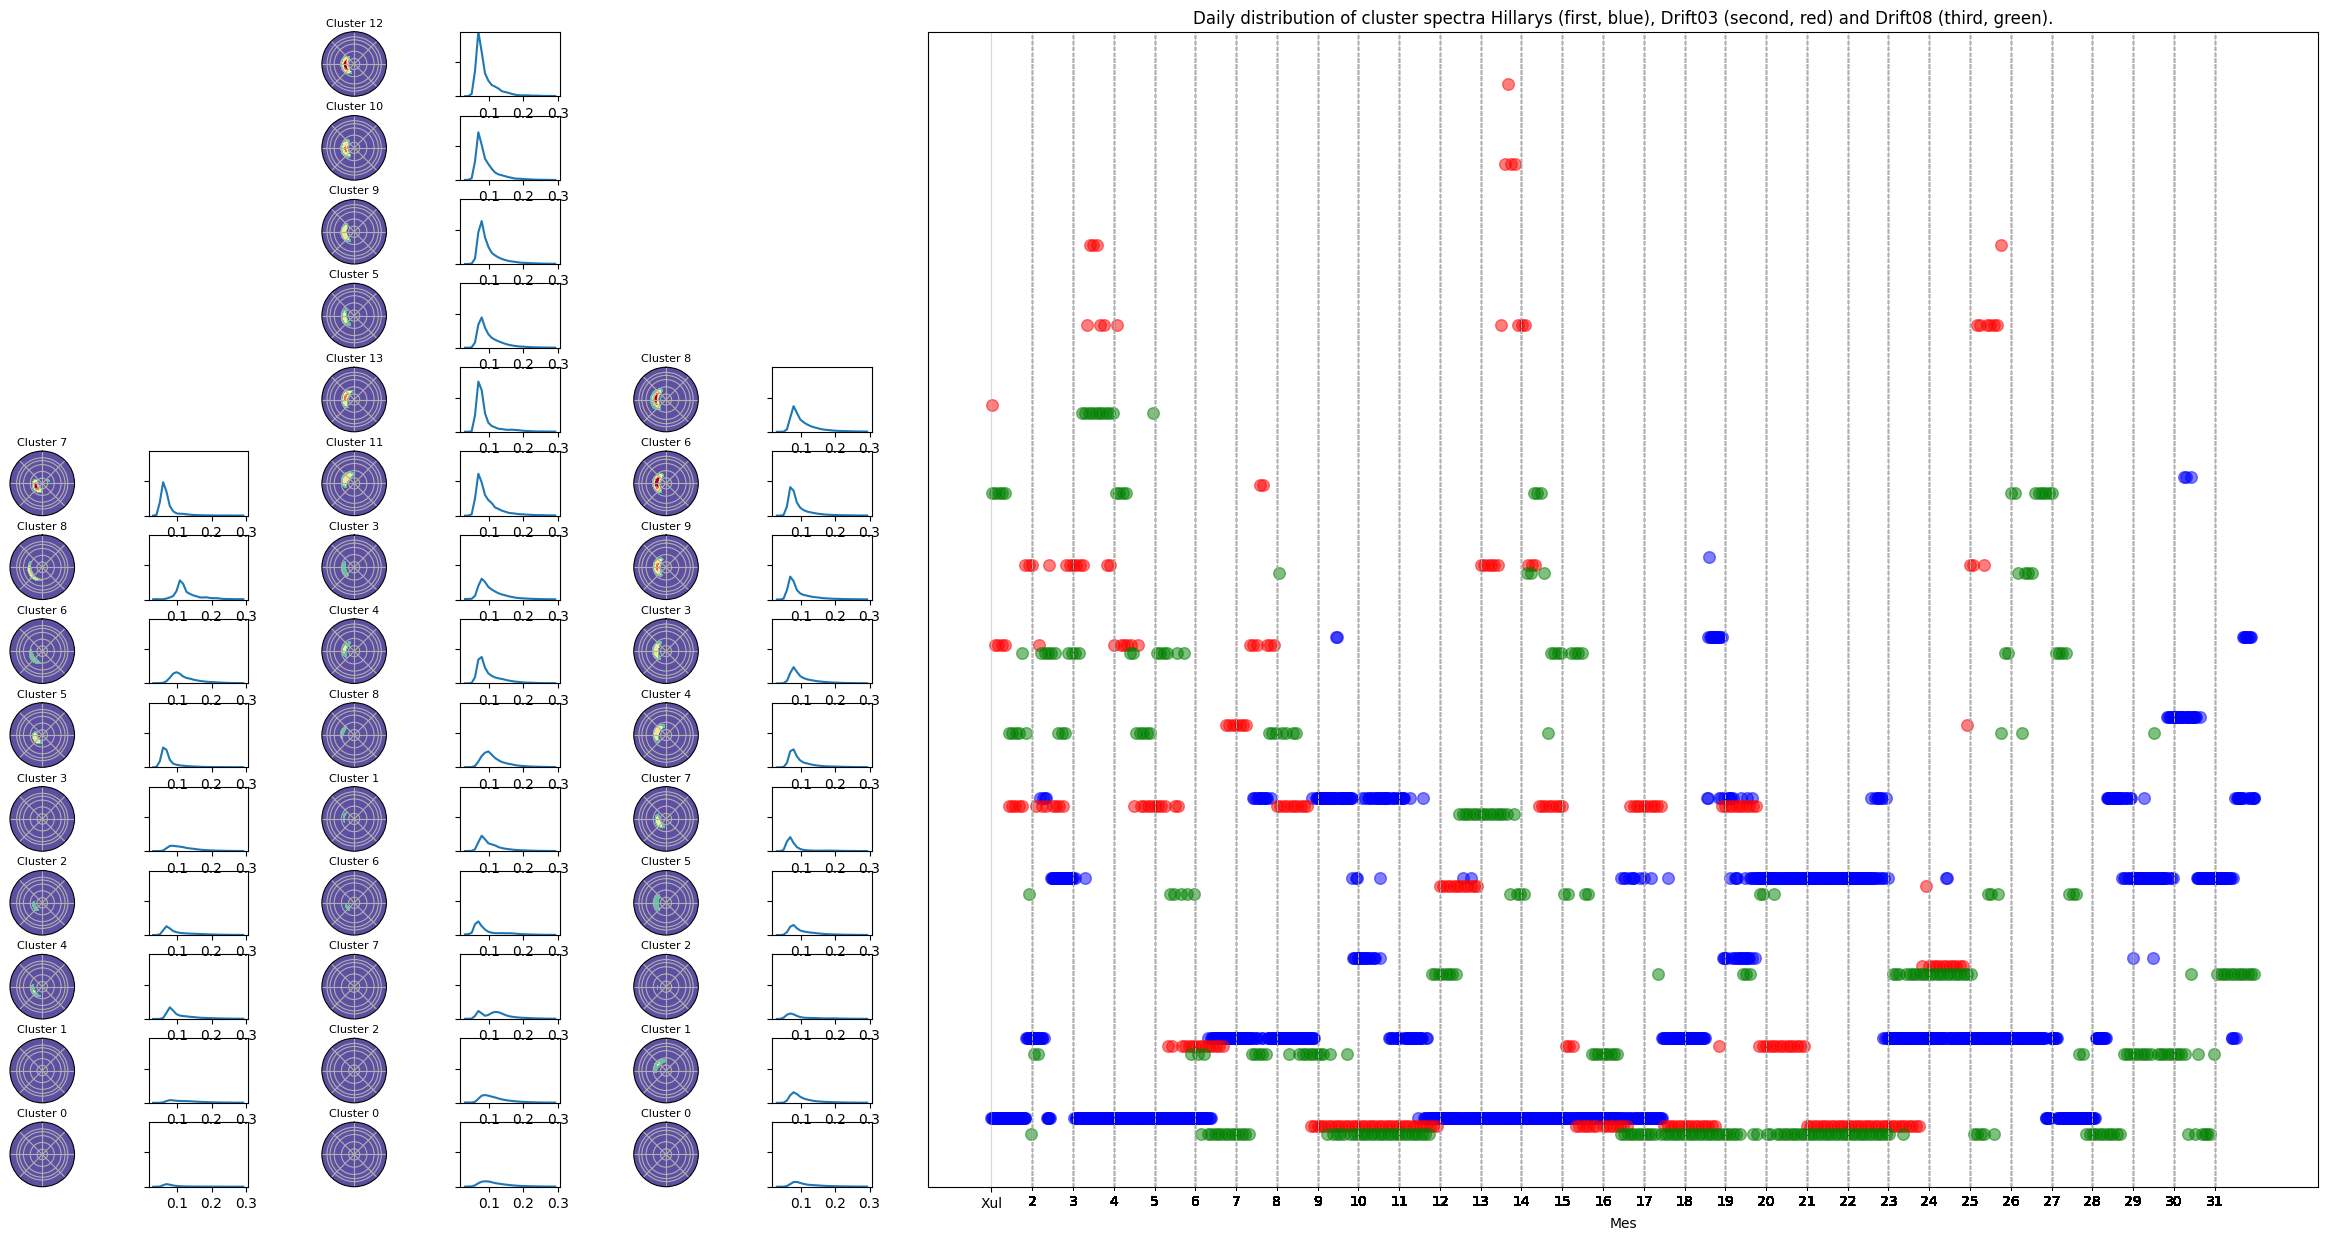

In [40]:
plot_cluster_spectrum_and_timeline_list([df_hillarys, df_drift03, df_drift06], [efth_ordered_hillarys, efth_ordered_drift03, efth_ordered_drift06], [n_clusters_hillarys_ord, n_clusters_drift03_ord, n_clusters_drift06_ord], title="Hillarys (first, blue), Drift03 (second, red) and Drift08 (third, green).", save="Buoy_cluster_comparison.png")

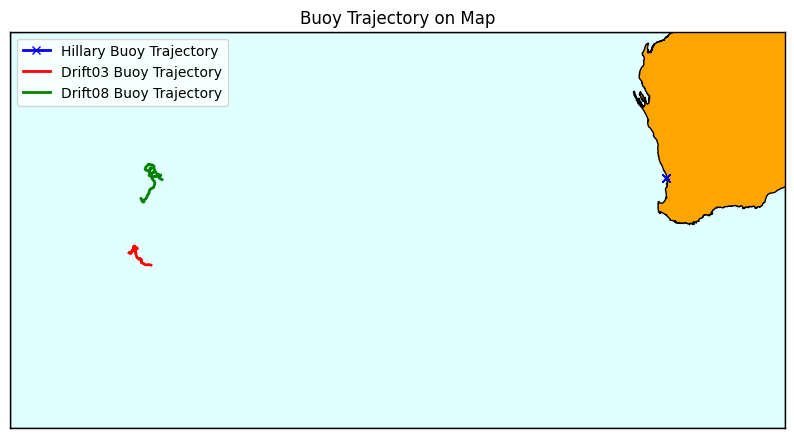

In [60]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

lon_h = np.array(f_hillary.get('SpotData/lon')).squeeze()
lat_h = np.array(f_hillary.get('SpotData/lat')).squeeze()
lon_d03 = np.array(f_drift03.get('SpotData/lon')).squeeze()
lat_d03 = np.array(f_drift03.get('SpotData/lat')).squeeze()
lon_d06 = np.array(f_drift06.get('SpotData/lon')).squeeze()
lat_d06 = np.array(f_drift06.get('SpotData/lat')).squeeze()

min_lat = np.min(np.concatenate([lat_h, lat_d03, lat_d06]))
max_lat = np.max(np.concatenate([lat_h, lat_d03, lat_d06]))
min_lon = np.min(np.concatenate([lon_h, lon_d03, lon_d06]))
max_lon = np.max(np.concatenate([lon_h, lon_d03, lon_d06]))

plt.figure(figsize=(10, 8))
m = Basemap(projection='merc',
            llcrnrlat=min_lat-10.0, urcrnrlat=max_lat+10.0,
            llcrnrlon=min_lon-10.0, urcrnrlon=max_lon+10.0,
            resolution='i')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='orange', lake_color='aqua')
m.drawmapboundary(fill_color='lightcyan')

x, y = m(lon_h, lat_h)
m.plot(x, y, marker='x', color='b', linewidth=2.0, label='Hillary Buoy Trajectory')
x, y = m(lon_d03, lat_d03)
m.plot(x, y, color='r', linewidth=2.0, label='Drift03 Buoy Trajectory')
x, y = m(lon_d06, lat_d06)
m.plot(x, y, color='g', linewidth=2.0, label='Drift08 Buoy Trajectory')
plt.title('Buoy Trajectory on Map')
plt.legend()
plt.savefig('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/map.png')
plt.show()


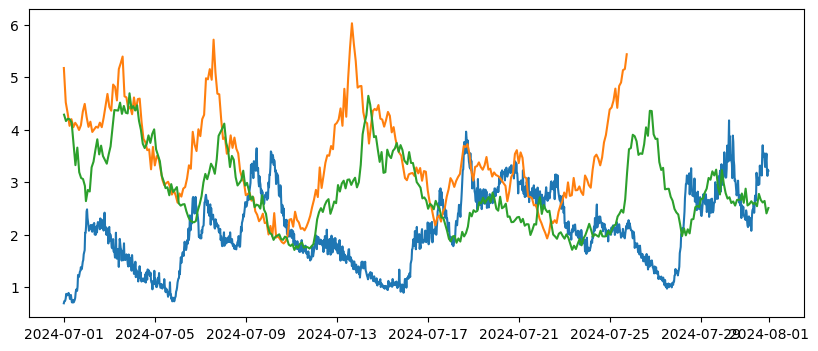

In [61]:
fig = plt.figure(figsize=(10,4))
plt.plot(data_time_hillarys, hs_h)
plt.plot(data_time_drift03, hs_d03)
plt.plot(data_time_drift06, hs_d06)

In [54]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from plotly.offline import plot
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.templates.default = 'plotly'

def plot_spectral_grid_mean(cluster_means, frequencies, directions):
    """
    Plots 3D spectral energy distributions using cluster mean tensors.

    Parameters:
        cluster_means (list of np.ndarray): List of K tensors representing cluster means.
        frequencies (np.ndarray): Frequency array corresponding to the clusters.
        directions (np.ndarray): Direction array corresponding to the clusters.
    """
    num_clusters = len(cluster_means)
    cols = min(2, num_clusters)
    rows = (num_clusters // cols) + (num_clusters % cols > 0)

    fig = make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=[f'Cluster {i__+1}' for i__ in range(num_clusters)],
        specs=[[{'type': 'surface'}] * cols for _ in range(rows)]
    )

    # Ensure directions include both 0° and 360°
    directions = np.append(directions, 360.0)  # Add 360° to the directions array
    directions_rad = np.radians(directions)  # Convert to radians

    # Extend cluster_means by repeating the values for 0° at 360°
    for i_ in range(len(cluster_means)):
        cluster_means[i_] = np.concatenate([cluster_means[i_], cluster_means[i_][:, [0]]], axis=1)

    # Generate meshgrid for plotting
    Freq, Theta = np.meshgrid(frequencies, directions_rad)
    X = Freq * np.cos(Theta)  # Use Freq as radial and Theta as angular
    Y = Freq * np.sin(Theta)

    # Loop through each cluster mean tensor and plot
    for idx, cluster_mean in enumerate(cluster_means):
        row, col = divmod(idx, cols)

        Z = cluster_mean.T  # Transpose for correct orientation

        surface = go.Surface(
            x=X,
            y=-Y,
            z=Z,
            colorscale='Spectral_r',
            opacity=1,
            showlegend=False,
            showscale=False
        )
        fig.add_trace(surface, row=row+1, col=col+1)

        # Add circles and directional labels
        max_frequency = np.max(frequencies)
        circle_radii = [0.75 * max_frequency, 0.5 * max_frequency, 0.25 * max_frequency]

        for freq in circle_radii:
            circle_x = freq * np.cos(np.linspace(0, 2 * np.pi, 100))
            circle_y = freq * np.sin(np.linspace(0, 2 * np.pi, 100))
            fig.add_trace(go.Scatter3d(
                x=circle_x,
                y=circle_y,
                z=np.zeros_like(circle_x),
                mode='lines',
                line=dict(color='black', width=0.5, dash='dash'),
                showlegend=False
            ), row=row+1, col=col+1)

        border_x = max_frequency * np.cos(np.linspace(0, 2 * np.pi, 100))
        border_y = max_frequency * np.sin(np.linspace(0, 2 * np.pi, 100))
        fig.add_trace(go.Scatter3d(
            x=border_x,
            y=border_y,
            z=np.zeros_like(border_x),
            mode='lines',
            line=dict(color='black', width=1),
            showlegend=False
        ), row=row+1, col=col+1)

        for angle in range(0, 360, 45):
            rad = np.radians(-angle)
            x = max_frequency * np.cos(rad)
            y = max_frequency * np.sin(rad)

            fig.add_trace(go.Scatter3d(
                x=[0, x],
                y=[0, y],
                z=[0, 0],
                mode='lines',
                line=dict(color='black', width=0.5, dash='dash'),
                showlegend=False
            ), row=row+1, col=col+1)
            fig.add_trace(go.Scatter3d(
                x=[x],
                y=[y],
                z=[0],
                mode='text',
                text=[f"{angle}°"],
                showlegend=False,
                textposition='bottom center'
            ), row=row+1, col=col+1)

    fig.update_layout(
        height=800 * rows,
        width=600 * cols,
        title_text='Cluster Mean Spectral Energy Distributions',
        showlegend=False,
    )

    for i in range(1, num_clusters + 1):
        fig.update_scenes(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=True),  # Ensure consistent z-axis scaling
            zaxis_range=[0, np.max(cluster_means)],  # Force consistent scale across plots
            bgcolor='rgba(0,0,0,0)',
            row=(i - 1) // cols + 1,
            col=(i - 1) % cols + 1
        )

    fig.show(renderer="svg")
    plot(fig, auto_open=False, filename='/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/plots/plot_means_directional_6.html')

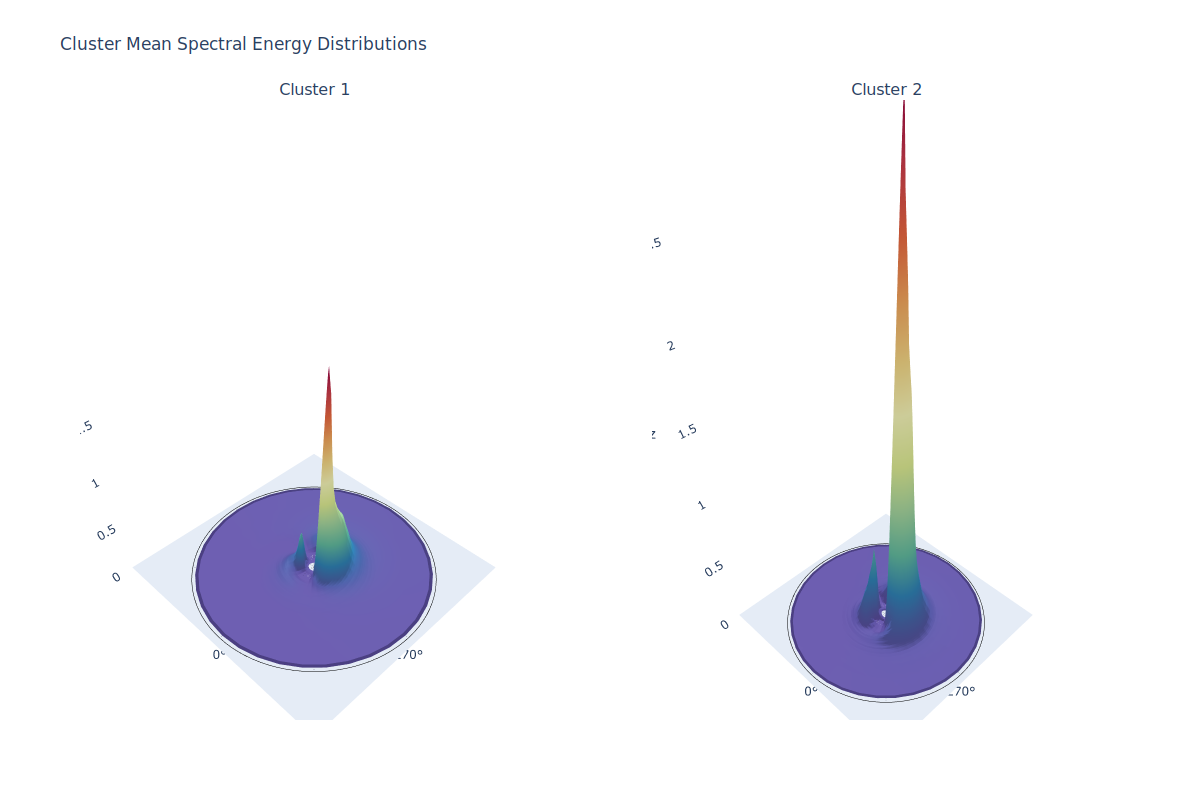

In [55]:
frequencies = freq_
directions_ = np.rad2deg(directions)
energy_spectral = data
tensors_list = []
for gp in sw_gp_hillary.gpmodels[0][:2]:
    subdata = np.mean(data[gp.indexes], axis=0)
    tensors_list.append(subdata)
plot_spectral_grid_mean(cluster_means=tensors_list, frequencies=frequencies, directions=directions_)

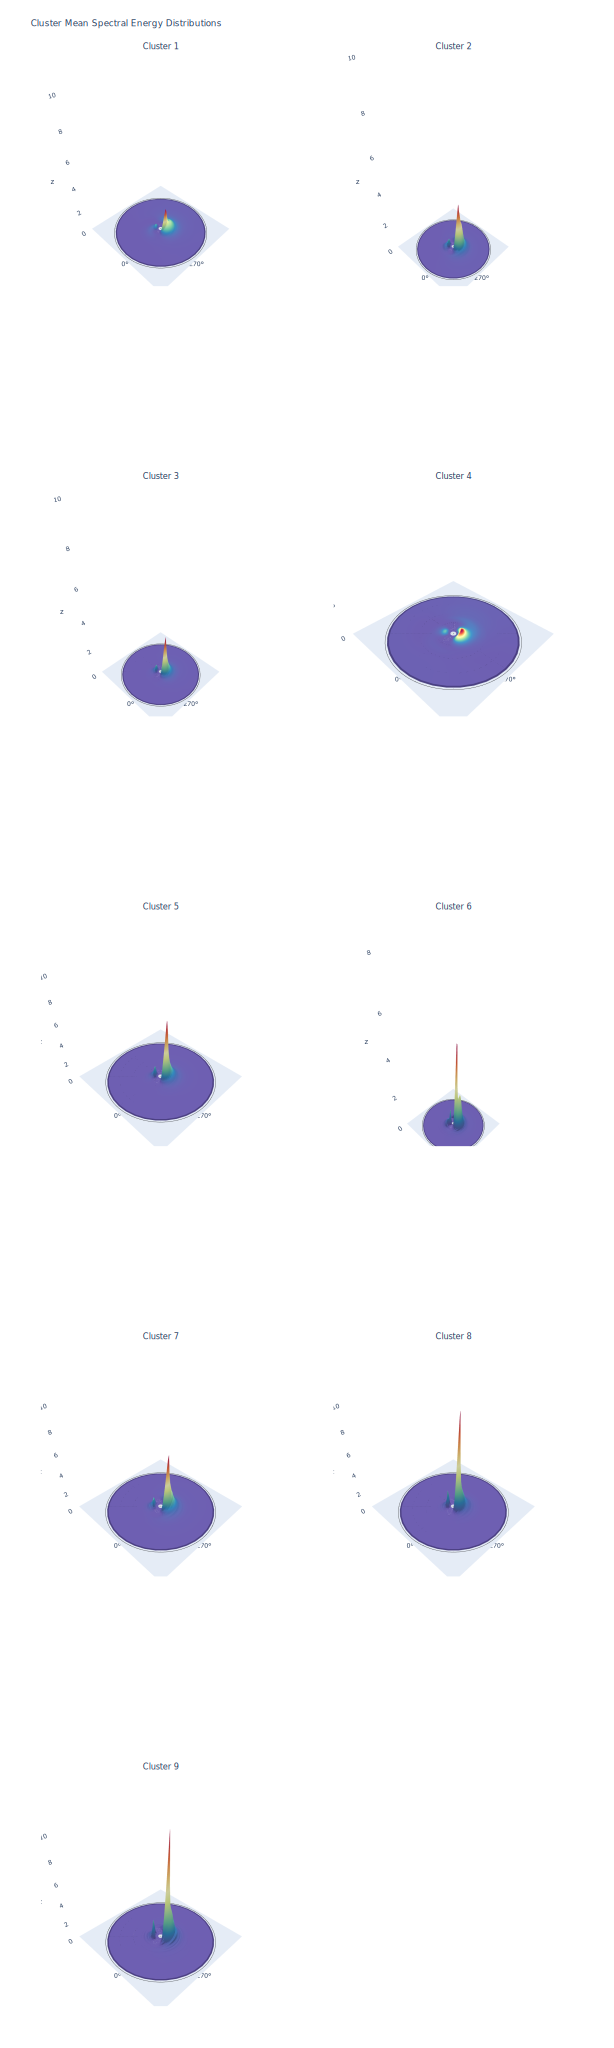

In [56]:
frequencies = freq_
directions_ = np.rad2deg(directions)
energy_spectral = data
tensors_list = []
for gp in sw_gp_hillary.gpmodels[0]:
    subdata = np.mean(data[gp.indexes], axis=0)
    tensors_list.append(subdata)
plot_spectral_grid_mean(cluster_means=tensors_list, frequencies=frequencies, directions=directions_)

---